In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit

fs = 18
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': fs})
from matplotlib.ticker import EngFormatter
from matplotlib.dates import DateFormatter

In [3]:
# User-defined PATH TO DATA REPOSITORY
litrev_dir = '/Users/Dana/Desktop/Jupyter/WISC/NaturalCommunity/lit_review_data_supp/' 


In [4]:
pump_range = []
pump_rates = []
for filename in os.listdir(litrev_dir +'pump_impacts'):
    
    try:
        pump_range = pump_range + [float(filename[:-12])]
        pump_rates = pump_rates + [filename[:-12]]
    except:
        print(filename[:-12])
        
air_temp = pd.read_csv(litrev_dir +'streamflow_data/temp_data_noaa.csv')[['DATE','TMAX']].set_index('DATE')
air_temp = air_temp.reset_index()
air_temp['DATE'] = pd.to_datetime(air_temp.DATE)
air_temp = air_temp.set_index('DATE')

In [5]:
# https://github.com/dadelforge/baseflow-separation/blob/master/physep/hysep.py
from scipy.ndimage.filters import minimum_filter1d, generic_filter

def fixed_interval_filter(ts, size):
    """USGS HYSEP fixed interval method
    
    The USGS HYSEP fixed interval method as described in `Sloto & Crouse, 1996`_.
    
    .. _Slot & Crouse, 1996:
        Sloto, Ronald A., and Michele Y. Crouse. “HYSEP: A Computer Program for Streamflow Hydrograph Separation and 
        Analysis.” USGS Numbered Series. Water-Resources Investigations Report. Geological Survey (U.S.), 1996. 
        http://pubs.er.usgs.gov/publication/wri964040.
    
    :param size: 
    :param ts: 
    :return: 
    """
    intervals = np.arange(len(ts)) // size
    baseflow = pd.Series(data=ts.groupby(intervals).transform('min'), index=ts.index)
    quickflow = ts - baseflow

    baseflow.name = 'baseflow'
    quickflow.name = 'quickflow'

    return baseflow, quickflow



In [6]:
# method to find break in slope and calculate trends on each side of break
# written by David Dralle

def func_broken_stick(x,threshold,b1,b2,a1):
    # a1, b1 are slope and intercept for left curve
    # b2 is slope for right curve
    # intercept on right curve is determined by the intersection constraint
    a2 = (b1*threshold - b2*threshold + a1)
    return np.where(x<threshold, b1*x+a1, b2*x+a2)

def broken_stick_fit(x, y, 
                    threshold_lower_percentile_bound=0,
                    threshold_upper_percentile_bound=100, 
                    slope_left_lower = -np.inf, 
                    slope_left_upper = np.inf,
                    slope_right_lower = -np.inf,
                    slope_right_upper = np.inf
                    ):
    """
    @desc:
    Fits broken stick, with constraints if desired. Note, if using for CQ power law fits, data should first
    be log-transformed.
    
    @params:
    threshold_upper_percentile: upper bound on possible thresholds determined through a percentile on the x data
    threshold_lower_percentile: lower bound on possible thresholds determined through a percentile on the x data
    slope_left_lower: lower constraint on left slope
    slope_left_upper: upper constraint on left slope
    slope_right_lower: lower constraint on right slope
    slope_right_upper: upper constraint on right slope
    
    @returns:
    popt: fitted broken stick paramters as a list
        [threshold: threshold for slope break, 
        b1: slope on left line, 
        b2: slope on right line,
        a1: intercept on left line]
        Note that if the curves intersect, the intercept on the right curve is constrained by the other fits
        a2 = (b1*threshold - b2*threshold + a1)
    standard_errors: standard errors for the fitted parameters
    """

    
    popt_temp, pcov_temp = curve_fit(func_broken_stick, x, y, 
                                    bounds = [(np.percentile(x,threshold_lower_percentile_bound), slope_left_lower, slope_right_lower, -np.inf), 
                                              (np.percentile(x,threshold_upper_percentile_bound), slope_left_upper, slope_right_upper, np.inf)
                                             ]
                                   )
    standard_errors = np.sqrt(np.diag(pcov_temp))
    return popt_temp, standard_errors

In [7]:
def calc_season_dates(temp):
    spring_check = temp[~(temp.isna())].loc[pd.to_datetime('1-1-1999'):pd.to_datetime('4-1-1999')]
    spring_check = spring_check[np.isfinite(spring_check)]
    popt_spring, error = broken_stick_fit(list(range(len(spring_check))),
                    spring_check)
    [threshold, b1, b2, a1] = popt_spring
    spring_start_date = (spring_check.index.values[int(round(threshold))])
    summer_check = temp[~(temp.isna())].loc[pd.to_datetime('5-1-1999'):pd.to_datetime('8-1-1999')]
    summer_check = summer_check[np.isfinite(summer_check)]
    popt_summer, error = broken_stick_fit(list(range(len(summer_check))),
                    summer_check)
    [threshold, b1, b2, a1] = popt_summer
    summer_start_date = (summer_check.index.values[int(round(threshold))])
    fall_check = temp[~(temp.isna())].loc[pd.to_datetime('7-1-1999'):pd.to_datetime('11-15-1999')]
    fall_check = fall_check[np.isfinite(fall_check)]
    popt_fall, error = broken_stick_fit(list(range(len(fall_check))),
                    fall_check)
    [threshold, b1, b2, a1] = popt_fall
    fall_start_date = (fall_check.index.values[int(round(threshold))])
    winter_check = temp[~(temp.isna())].loc[pd.to_datetime('10-1-1999'):pd.to_datetime('12-31-1999')]
    winter_check = winter_check[np.isfinite(winter_check)]
    popt_winter, error = broken_stick_fit(list(range(len(winter_check))),
                    winter_check)
    [threshold, b1, b2, a1] = popt_winter
    winter_start_date = (winter_check.index.values[int(round(threshold))])
    return([spring_start_date,summer_start_date,fall_start_date,winter_start_date])

def winter_metrics(df,seasons):
    winterdf = df.reset_index()[df.reset_index().datetime.dt.month>seasons[3].month].set_index('datetime')
    winterdf1 = df.reset_index()[df.reset_index().datetime.dt.month<seasons[0].month].set_index('datetime')
    winterdf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[0].month) &
                                (df.reset_index().datetime.dt.day<seasons[0].day)].set_index('datetime')
    winterdf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[3].month) &
                                (df.reset_index().datetime.dt.day>=seasons[3].day)].set_index('datetime')
    temp = pd.concat([winterdf,winterdf1,winterdf2,winterdf3])
    mean_daily = np.nanmean(temp)
    min_daily = []
#     max_daily = []
    min_date = []
    T5_date = []
    T75_date = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    DD2_5 = []
    freq_below2 = []
    freq_below0 = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        T5_date = T5_date +[pd.to_datetime(t[t==np.nanpercentile(t,5)].index.values[0])]
        T75_date = T75_date + [pd.to_datetime(t[t==np.nanpercentile(t,75)].index.values[0])]
        DD25 = np.array(t.values)-np.array([2.5]*len(t))
        DD25 = np.nansum(np.where(DD25<0,abs(np.array(DD25)),0))
        DD2_5 = DD2_5 + [DD25]
        num2 = 0
        below = False
        for i in range(len(t)):
            if t.values[i]<2 and below==False:
                num2 +=1
                below = True
            if t.values[i]>2 and below==True:
                below = False
        freq_below2 = freq_below2 + [num2]
        num0 = 0
        below = False
        for i in range(len(t)):
            if t.values[i]<0 and below==False:
                num0 +=1
                below = True
            elif t.values[i]>0 and below==True:
                below = False
        freq_below0 = freq_below0 + [num0]
        min_daily = min_daily + [np.nanmin(t)]
        min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
    min_daily = np.nanmean(min_daily)
    min_date = ["%02d%02d" %(min_date[i].month,min_date[i].day) for i in range(len(min_date))]
    min_date = sorted(min_date)[len(min_date)//2]
    min_date = pd.to_datetime(min_date[:2]+'-'+min_date[2:]+'-1999')
    T5_date = ["%02d-%02d"%(T5_date[i].month, T5_date[i].day) for i in range(len(T5_date))]
    T5_date = sorted(T5_date)[len(T5_date)//2]
    T5_date = pd.to_datetime(T5_date[:2]+'-'+T5_date[2:]+'-1999')
    T75_date = ["%02d-%02d" % (T75_date[i].month,T75_date[i].day) for i in range(len(T75_date))]
    T75_date = sorted(T75_date)[len(T75_date)//2]
    T75_date = pd.to_datetime(T75_date[:2]+T75_date[2:]+'-1999')
    freq_below2 = np.nanmean(freq_below2)
    freq_below0 = np.nanmean(freq_below0)
    below2 = len(temp[temp<=2])/num_years
    above4_5 = len(temp[temp>=4.5])/num_years
    cv = np.nanstd(temp)/np.nanmean(temp)
    DD2_5 = np.nanmean(DD2_5)
    return({'mean_daily':mean_daily,'T5_date':T5_date, 'T75_date':T75_date,
            'CV':cv, 'DD2.5':DD2_5, 'min_date':min_date, 'min_daily':min_daily,
           'below2':below2, 'freq_below2':freq_below2, 'freq_freeze':freq_below0,
           'above4.5':above4_5})

def spring_metrics(df,seasons):
    springdf = df.reset_index()[(df.reset_index().datetime.dt.month>seasons[0].month) &
                               (df.reset_index().datetime.dt.month<seasons[1].month)].set_index('datetime')
    springdf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[0].month) &
                                (df.reset_index().datetime.dt.day>=seasons[0].day)].set_index('datetime')
    springdf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[1].month) &
                                (df.reset_index().datetime.dt.day<seasons[1].day)].set_index('datetime')
    temp = pd.concat([springdf,springdf2,springdf3])
    mean_daily = np.nanmean(temp)
    min_daily = []
    max_daily = []
    min_date = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        min_daily = min_daily + [np.nanmin(t)]
        max_daily = max_daily + [np.nanmax(t)]
    max_daily = np.nanmean(max_daily)
    cv = np.nanstd(temp)/np.nanmean(temp)
    return({'mean_daily':mean_daily,'CV':cv})

def summer_metrics(df,seasons):
    summerdf = df.reset_index()[(df.reset_index().datetime.dt.month>seasons[1].month) &
                               (df.reset_index().datetime.dt.month<seasons[2].month)].set_index('datetime')
    summerdf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[1].month) &
                                (df.reset_index().datetime.dt.day>=seasons[1].day)].set_index('datetime')
    summerdf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[2].month) &
                                (df.reset_index().datetime.dt.day<seasons[2].day)].set_index('datetime')
    temp = pd.concat([summerdf,summerdf2,summerdf3])
    mean_daily = np.nanmean(temp)
    max_daily = []
    max_date = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    event_above25 = []
    DD25 = []
    median_daily_roc = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        max_daily = max_daily + [np.nanmax(t)]
        max_date = t[t==np.nanmax(t)].index.values[0]
        above25 = 0
        hot = False
        for i in range(len(t)):
            if t.values[i]>25 and hot==False:
                hot = True
                above25+=1
            elif t.values[i]<25 and hot==True:
                hot = False
        event_above25 = event_above25 + [above25]
        DD25_annual = np.array(t.values)-np.array([25]*len(t))
        DD25_annual = np.where(DD25_annual<0,0,DD25_annual)
        DD25 = DD25 + [np.nansum(DD25_annual)]
        daily_roc = np.array(t.values)[1:]-np.array(t.values[:-1])
        median_daily_roc = median_daily_roc + [np.nanmedian(daily_roc)]
    max_daily = np.nanmean(max_daily)
    max_date = (np.array(max_date, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    mean_5day = temp.resample('5D').max()
    mean_5day = np.nanmean(mean_5day)
    event_above25 = np.nanmean(event_above25)
    above25 = len(temp[temp>=22])/num_years
    cv = np.nanstd(temp)/np.nanmean(temp)
    weekly_range = temp.resample('7D').max()-temp.resample('7D').min()
    weekly_range = np.nanmean(weekly_range)
    DD25 = np.nanmean(DD25)
    median_daily_roc = np.nanmean(median_daily_roc)
    return({'mean_daily':mean_daily,'max_daily':max_daily,
            'max_date':max_date,'events>25':event_above25, 'DD25':DD25,
            'weekly_range':weekly_range,'median_daily_roc':median_daily_roc,
            'mean_5day':mean_5day,
                     'CV':cv})

def fall_metrics(df,seasons):
    falldf = df.reset_index()[(df.reset_index().datetime.dt.month>seasons[2].month) &
                               (df.reset_index().datetime.dt.month<seasons[3].month)].set_index('datetime')
    falldf2 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[2].month) &
                                (df.reset_index().datetime.dt.day>=seasons[2].day)].set_index('datetime')
    falldf3 = df.reset_index()[(df.reset_index().datetime.dt.month==seasons[3].month) &
                                (df.reset_index().datetime.dt.day<seasons[3].day)].set_index('datetime')
    temp = pd.concat([falldf,falldf2,falldf3])
    mean_daily = np.nanmean(temp)
    max_daily = []
    years = temp.reset_index().datetime.dt.year.drop_duplicates().values
    num_years = len(years)
    roc = []
    for yr in years:
        t = temp.reset_index()[temp.reset_index().datetime.dt.year==yr].set_index('datetime')
        max_daily = max_daily + [np.nanmax(t)]
        roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
    max_daily = np.nanmean(max_daily)
    cv = np.nanstd(temp)/np.nanmean(temp)
    roc = np.nanmean(roc)
    return({'mean_daily':mean_daily,'roc':roc})


def calc_diff(metric,metric_impact,season):
    diff = {}
    for key in metric.keys():
        if key in ['min_date','max_date','T5_date','T75_date',]:
            diff[season+'_'+key] = (pd.to_datetime(metric_impact[key])-pd.to_datetime(metric[key]))
        elif key in ['mean_daily','max_daily','min_daily','mean_5day']:
            diff[season+'_'+key] = metric_impact[key]-metric[key]
        elif key in ['roc','CV','median_daily_roc','weekly_range','event_above25','DD25','DD2.5',
                    'below2','freq_below2','freq_freeze','above4.5']:
            diff[season+'_'+key] = (metric_impact[key]-metric[key])/metric[key]*100
    return(diff)

def calc_metrics(df):
    # first, annualize this thing
    df_1yr = df.reset_index()
    df_1yr = df_1yr[(df_1yr.datetime.dt.day!=29) | (df_1yr.datetime.dt.month!=2)]
    df_1yr['datetime'] = np.where(df_1yr.datetime.dt.month>=1,
                                 df_1yr['datetime'].apply(lambda x: x.replace(year = 1999)),
                                 df_1yr['datetime'].apply(lambda x: x.replace(year = 1999)))
    df_1yr = df_1yr.sort_index()
    df_1yr = df_1yr.set_index('datetime')
    seasons = calc_season_dates(df_1yr.guess_temp.resample('D').mean())
    seasons_impact = calc_season_dates(df_1yr.impact_temp.resample('D').mean())
    seasons = [pd.to_datetime(seasons[i]) for i in range(len(seasons))]
    seasons_impact = [pd.to_datetime(seasons_impact[i]) for i in range(len(seasons_impact))]
    
    
    winter = winter_metrics(df.guess_temp,seasons)
    winter_impact = winter_metrics(df.impact_temp,seasons_impact)
    print(winter)
    print(winter_impact)
    winter_diff = calc_diff(winter,winter_impact,'winter')
    
    spring = spring_metrics(df.guess_temp,seasons)
    spring_impact = spring_metrics(df.impact_temp,seasons_impact)
    spring_diff = calc_diff(spring,spring_impact,'spring')
    
    summer = summer_metrics(df.guess_temp,seasons)
    summer_impact = summer_metrics(df.impact_temp,seasons_impact)
    summer_diff = calc_diff(summer,summer_impact,'summer')

    
    fall = fall_metrics(df.guess_temp,seasons)
    fall_impact = fall_metrics(df.impact_temp,seasons_impact)
    fall_diff = calc_diff(fall,fall_impact,'fall')
    
    metric_diff = winter_diff
    metric_diff.update(spring_diff)
    metric_diff.update(summer_diff)
    metric_diff.update(fall_diff)
    return(metric_diff)


In [8]:
baseflow_temp = 9.9 # set to 9.9 deg Celsius, which is the median mean annual streamflow temp. across all sites with temp. data
window_size = 5000 # window size for baseflow separation (hours)


metric_impact = {}

USGS_ref = os.listdir(litrev_dir+'streamflow_data')
USGS_ref = [f for f in USGS_ref if f!='temp_data_noaa.csv']

for site in USGS_ref:
    site_num = site
    flow_data = pd.read_csv(litrev_dir+'streamflow_data/'+site_num)
    flow_data = flow_data.reset_index()
    flow_data['datetime'] = pd.to_datetime(flow_data.datetime)
    flow_data['discharge_cmd'] = flow_data.Q_m3d
    flow_data = flow_data.set_index('datetime')
    flow_data['air_temp'] = flow_data.merge(air_temp,left_index=True,right_index=True,how='left').TMAX.ffill()


    baseflow,quickflow = fixed_interval_filter(flow_data.discharge_cmd,window_size)
    flow_data['baseflow'] = baseflow
    flow_data['quickflow'] = quickflow
    flow_data['guess_temp'] = (flow_data.baseflow*baseflow_temp+flow_data.quickflow.mul(flow_data.air_temp,axis=0))
    flow_data['guess_temp'] = flow_data.guess_temp.mul(1/flow_data.discharge_cmd,axis=0)


    # pick pump rate as 1.25 times baseflow median
    pump_rate = np.nanmedian(flow_data.baseflow)*1.25
    print(pump_rate)
    pumprate_diff = abs(pump_range-pump_rate)
    pump_rate = pump_rates[list(pumprate_diff).index(min(pumprate_diff))]

    impacts = pd.read_csv(litrev_dir+'pump_impacts/'+str(pump_rate)+'_impacts.csv').drop(columns=['Unnamed: 0','times'])
    flow_data = (flow_data.reset_index().merge(impacts,left_index=True,right_index=True)).set_index('datetime')
    flow_data['discharge_impact'] = flow_data.discharge_cmd-flow_data.Qs
    baseflow_impact,quickflow_impact = fixed_interval_filter(flow_data.discharge_impact,window_size)
    flow_data['baseflow_impact'] = baseflow_impact
    flow_data['quickflow_impact'] = quickflow_impact
    flow_data['impact_temp'] = (flow_data.baseflow_impact*baseflow_temp+flow_data.quickflow_impact.mul(flow_data.air_temp,axis=0))
    flow_data['impact_temp'] = flow_data.impact_temp.mul(1/flow_data.discharge_impact,axis=0)

    flow_data = flow_data.sort_index()
    impacts = calc_metrics(flow_data)

    if metric_impact=={}:
        for key in impacts:
            metric_impact[key] = [impacts[key]]
    else:
        for key in metric_impact:
            metric_impact[key] = metric_impact[key]+[impacts[key]]


59.34480383868299
{'mean_daily': -0.013936908607535006, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -390.9616467767913, 'DD2.5': 10346.931549653134, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.090427944662151, 'below2': 55.529411764705884, 'freq_below2': 5.352941176470588, 'freq_freeze': 5.176470588235294, 'above4.5': 55.529411764705884}
{'mean_daily': -0.2101469094859231, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -26.410267329155133, 'DD2.5': 10826.510762106343, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.504592287649011, 'below2': 55.529411764705884, 'freq_below2': 5.352941176470588, 'freq_freeze': 5.411764705882353, 'above4.5': 55.529411764705884}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


311.7026112320931
{'mean_daily': 1.340126172924761, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.4946085480734745, 'DD2.5': 4674.818712729454, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.657865511805362, 'below2': 45.23076923076923, 'freq_below2': 5.769230769230769, 'freq_freeze': 4.6923076923076925, 'above4.5': 45.23076923076923}
{'mean_daily': 0.23102969210011126, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 22.59254852476966, 'DD2.5': 6680.182365837889, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.109169602240723, 'below2': 46.15384615384615, 'freq_below2': 5.615384615384615, 'freq_freeze': 5.538461538461538, 'above4.5': 46.15384615384615}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


408.771720987547


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.723451845703027, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6893254764238588, 'DD2.5': 860.5936345201037, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.36843266279494885, 'below2': 71.70967741935483, 'freq_below2': 1.967741935483871, 'freq_freeze': 1.032258064516129, 'above4.5': 71.70967741935483}
{'mean_daily': 3.4209128633269783, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1756761526268564, 'DD2.5': 1816.8742051911747, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.89049522708212, 'below2': 66.87096774193549, 'freq_below2': 2.935483870967742, 'freq_freeze': 1.935483870967742, 'above4.5': 66.87096774193549}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

229.53088480568582
{'mean_daily': 5.484083479512321, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9021163825322196, 'DD2.5': 1689.235296857366, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.8031435824617352, 'below2': 72.38709677419355, 'freq_below2': 2.7419354838709675, 'freq_freeze': 1.3870967741935485, 'above4.5': 72.38709677419355}
{'mean_daily': 5.146499604598556, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0287639646760467, 'DD2.5': 2095.7842548924305, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.8277746340622762, 'below2': 72.38709677419355, 'freq_below2': 3.3870967741935485, 'freq_freeze': 1.6129032258064515, 'above4.5': 72.38709677419355}
83.00089996183367
{'mean_daily': 3.5086193003327693, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2272872882088872, 'DD2.5': 2724.2484135649206, 'mi

<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


26.13237787975068
{'mean_daily': 0.5972881210602035, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 9.146202748214252, 'DD2.5': 10221.390324254024, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.179103597872489, 'below2': 65.3225806451613, 'freq_below2': 6.032258064516129, 'freq_freeze': 5.838709677419355, 'above4.5': 65.3225806451613}
{'mean_daily': 1.6835550621051043, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 3.630966491828764, 'DD2.5': 17229.308824423766, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -12.064837852440258, 'below2': 87.29032258064517, 'freq_below2': 8.0, 'freq_freeze': 7.967741935483871, 'above4.5': 87.29032258064517}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


773.1699540722302


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.471769849877161, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1457385810777234, 'DD2.5': 2938.32046337521, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.6488250858885785, 'below2': 84.18181818181819, 'freq_below2': 1.9090909090909092, 'freq_freeze': 1.5909090909090908, 'above4.5': 84.18181818181819}
{'mean_daily': 0.7620718507008272, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 8.33612085911885, 'DD2.5': 3362.8895749907547, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.940772876612998, 'below2': 56.36363636363637, 'freq_below2': 2.1363636363636362, 'freq_freeze': 2.0454545454545454, 'above4.5': 56.36363636363637}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-package

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encount

768.7281205497264


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 5.414692371128393, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5974892266660706, 'DD2.5': 968.306394783523, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.5234275204346787, 'below2': 74.12903225806451, 'freq_below2': 2.161290322580645, 'freq_freeze': 0.967741935483871, 'above4.5': 74.12903225806451}
{'mean_daily': 3.5943306148452785, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0988388350638907, 'DD2.5': 2301.5935493226743, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.5987836621111646, 'below2': 69.12903225806451, 'freq_below2': 4.064516129032258, 'freq_freeze': 2.5161290322580645, 'above4.5': 69.12903225806451}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1077.8309694845204
{'mean_daily': 7.863416730762648, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.35846638421594634, 'DD2.5': 152.5324335735356, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.7335196777141237, 'below2': 107.45161290322581, 'freq_below2': 0.2903225806451613, 'freq_freeze': 0.16129032258064516, 'above4.5': 107.45161290322581}
{'mean_daily': 7.355623706039337, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.4703958283182864, 'DD2.5': 338.4076372087683, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.3471451935064533, 'below2': 110.35483870967742, 'freq_below2': 0.6451612903225806, 'freq_freeze': 0.1935483870967742, 'above4.5': 110.35483870967742}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


649.0848588219802


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.769609574769235, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6005513916331184, 'DD2.5': 406.9514497105513, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.7542021551629688, 'below2': 78.64516129032258, 'freq_below2': 1.096774193548387, 'freq_freeze': 0.5806451612903226, 'above4.5': 78.64516129032258}
{'mean_daily': 4.994841548481766, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7797295838979054, 'DD2.5': 614.7772809152046, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.651415609089625, 'below2': 71.87096774193549, 'freq_below2': 1.5161290322580645, 'freq_freeze': 0.8064516129032258, 'above4.5': 71.87096774193549}
130.11147533838002


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.622400023364458, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8010297305341029, 'DD2.5': 1299.3609181090892, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.207224801156564, 'below2': 88.0, 'freq_below2': 1.7096774193548387, 'freq_freeze': 0.8709677419354839, 'above4.5': 88.0}
{'mean_daily': 6.565601821880578, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.862408141463254, 'DD2.5': 1554.0196547896232, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.7994009529119149, 'below2': 89.0, 'freq_below2': 1.935483870967742, 'freq_freeze': 1.064516129032258, 'above4.5': 89.0}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1006.189307854695


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.397366748739036, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.48549108105764954, 'DD2.5': 491.521196990006, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.0807461290117906, 'below2': 76.6774193548387, 'freq_below2': 0.8064516129032258, 'freq_freeze': 0.3548387096774194, 'above4.5': 76.6774193548387}
{'mean_daily': 5.209801457600369, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7404497265153843, 'DD2.5': 1106.0812880898143, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.6422275910289051, 'below2': 76.6774193548387, 'freq_below2': 2.032258064516129, 'freq_freeze': 0.8064516129032258, 'above4.5': 76.6774193548387}
87.17798809724142
{'mean_daily': -0.36483678311045126, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -15.804570461809316, 'DD2.5': 11849.344679364649, 'min_date': Timestamp('19

<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


83.5224792465902


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 2.500238153908876, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.9165718290201121, 'DD2.5': 2881.185662680263, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.5734210964799, 'below2': 60.29032258064516, 'freq_below2': 3.806451612903226, 'freq_freeze': 2.5161290322580645, 'above4.5': 60.29032258064516}
{'mean_daily': 2.3108617994376512, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.115617526873141, 'DD2.5': 3105.463525689215, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.960332292684796, 'below2': 60.29032258064516, 'freq_below2': 3.870967741935484, 'freq_freeze': 2.6451612903225805, 'above4.5': 60.29032258064516}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

271.456067195867
{'mean_daily': 1.1426721146491818, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.349551095244023, 'DD2.5': 10717.313064245807, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.221247747458284, 'below2': 64.54838709677419, 'freq_below2': 7.483870967741935, 'freq_freeze': 6.483870967741935, 'above4.5': 64.54838709677419}
{'mean_daily': -0.23328066375186077, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -24.48143002178637, 'DD2.5': 15030.218967246632, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.058559321828106, 'below2': 63.54838709677419, 'freq_below2': 6.903225806451613, 'freq_freeze': 6.870967741935484, 'above4.5': 63.54838709677419}
1165.8433320022546


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.60645982506178, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6077385292479811, 'DD2.5': 894.4185646339984, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.198078546978147, 'below2': 78.30434782608695, 'freq_below2': 1.9565217391304348, 'freq_freeze': 1.0434782608695652, 'above4.5': 78.30434782608695}
{'mean_daily': 3.943538970959378, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.142575777059231, 'DD2.5': 2700.436234813475, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.1685218370029045, 'below2': 78.34782608695652, 'freq_below2': 2.8260869565217392, 'freq_freeze': 2.0869565217391304, 'above4.5': 78.34782608695652}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encount

-1395.721961669662
{'mean_daily': -5.900066157920384, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.85051685481583, 'DD2.5': 14674.912385846048, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -27.667258892378406, 'below2': 41.0, 'freq_below2': 4.1, 'freq_freeze': 3.85, 'above4.5': 41.0}
{'mean_daily': -5.901972982038284, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.8503103656358497, 'DD2.5': 14677.814737831888, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -27.675954987250815, 'below2': 41.0, 'freq_below2': 4.1, 'freq_freeze': 3.85, 'above4.5': 41.0}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


671.648976733241


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 2.9941332147952813, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.644633577560108, 'DD2.5': 1525.7915347318938, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.034212266328363, 'below2': 61.75, 'freq_below2': 1.5714285714285714, 'freq_freeze': 1.25, 'above4.5': 61.75}
{'mean_daily': 2.0086924478467565, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 3.7184341640520318, 'DD2.5': 5436.003226811308, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -11.145886936290424, 'below2': 82.0, 'freq_below2': 2.357142857142857, 'freq_freeze': 2.25, 'above4.5': 82.0}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<i

<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:]

773.2198251864442


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 4.8888199407197375, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7274445743860063, 'DD2.5': 873.4582209566858, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.7076696148453352, 'below2': 66.06451612903226, 'freq_below2': 1.8709677419354838, 'freq_freeze': 1.064516129032258, 'above4.5': 66.06451612903226}
{'mean_daily': 3.536503834799116, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2551377675910946, 'DD2.5': 1874.7263388293325, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.649032487564736, 'below2': 64.12903225806451, 'freq_below2': 3.064516129032258, 'freq_freeze': 1.903225806451613, 'above4.5': 64.12903225806451}
1813.764521991254


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.556705469569294, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.343665839452843, 'DD2.5': 223.90726142845813, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.842508872223358, 'below2': 76.82758620689656, 'freq_below2': 0.6896551724137931, 'freq_freeze': 0.20689655172413793, 'above4.5': 76.82758620689656}
{'mean_daily': 5.8733035270877085, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.4625333038401386, 'DD2.5': 701.9606890856118, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.26669017011320545, 'below2': 79.75862068965517, 'freq_below2': 2.0689655172413794, 'freq_freeze': 0.5862068965517241, 'above4.5': 79.75862068965517}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-

620.9930015017137
{'mean_daily': 4.5380383145163945, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7559639332211969, 'DD2.5': 2317.8240751954036, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.574124916635482, 'below2': 69.29032258064517, 'freq_below2': 4.064516129032258, 'freq_freeze': 2.3225806451612905, 'above4.5': 69.29032258064517}
{'mean_daily': 2.9746107361123038, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.4951523755604006, 'DD2.5': 5276.796893230415, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.12285187411154, 'below2': 66.29032258064517, 'freq_below2': 5.290322580645161, 'freq_freeze': 4.032258064516129, 'above4.5': 66.29032258064517}
685.8661148673325


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.143994530966105, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7625929991771759, 'DD2.5': 456.01879654611406, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.7914150663160887, 'below2': 52.32258064516129, 'freq_below2': 0.8064516129032258, 'freq_freeze': 0.5161290322580645, 'above4.5': 52.32258064516129}
{'mean_daily': 4.629353067554555, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9245384616603558, 'DD2.5': 611.9844118869037, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.333566347110845, 'below2': 52.32258064516129, 'freq_below2': 1.1612903225806452, 'freq_freeze': 0.5806451612903226, 'above4.5': 52.32258064516129}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

7.770717418190452


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 1.0815134051656081, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.3546573301090135, 'DD2.5': 4506.677674885465, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.444107506698659, 'below2': 56.0, 'freq_below2': 3.7857142857142856, 'freq_freeze': 3.25, 'above4.5': 56.0}
{'mean_daily': 0.9419339072402273, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 6.269330964283191, 'DD2.5': 4900.401550617103, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.15041388602536, 'below2': 57.0, 'freq_below2': 3.75, 'freq_freeze': 3.5714285714285716, 'above4.5': 57.0}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

21.323091687078545


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 1.9575130026388732, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.6375304341650816, 'DD2.5': 5614.101550479441, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.927645465007972, 'below2': 69.16, 'freq_below2': 4.4, 'freq_freeze': 3.72, 'above4.5': 69.16}
{'mean_daily': 1.8261102639063442, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.8430455338278775, 'DD2.5': 5650.340371559624, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.119602951350604, 'below2': 68.2, 'freq_below2': 4.28, 'freq_freeze': 3.84, 'above4.5': 68.2}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

17.521534685305703


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 0.18179581275011075, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 32.857357060213566, 'DD2.5': 6310.467833977654, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.315732204926881, 'below2': 53.857142857142854, 'freq_below2': 3.9285714285714284, 'freq_freeze': 3.857142857142857, 'above4.5': 53.857142857142854}
{'mean_daily': 0.04520303289463523, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 134.52811413637806, 'DD2.5': 6530.334482309837, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.609601913520152, 'below2': 53.857142857142854, 'freq_below2': 3.857142857142857, 'freq_freeze': 3.857142857142857, 'above4.5': 53.857142857142854}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


49.84663060339468


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 3.8672860921032246, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.6193629889705374, 'DD2.5': 6539.139692379345, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -5.795317433328203, 'below2': 85.9, 'freq_below2': 3.966666666666667, 'freq_freeze': 3.1, 'above4.5': 85.9}
{'mean_daily': 3.826105366369894, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.6498990371995579, 'DD2.5': 6660.303693414663, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -5.93764364505206, 'below2': 85.9, 'freq_below2': 3.966666666666667, 'freq_freeze': 3.1333333333333333, 'above4.5': 85.9}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


574.9598200772563


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.9027344514573645, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5857849279930546, 'DD2.5': 300.07191821706124, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.820567785033625, 'below2': 85.87096774193549, 'freq_below2': 0.9354838709677419, 'freq_freeze': 0.3225806451612903, 'above4.5': 85.87096774193549}
{'mean_daily': 6.62988667523981, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7297940044013708, 'DD2.5': 671.0807226109331, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.3066830446082482, 'below2': 87.90322580645162, 'freq_below2': 1.3225806451612903, 'freq_freeze': 0.6451612903225806, 'above4.5': 87.90322580645162}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

681.1169878377987
{'mean_daily': 4.125632186473516, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0524927156381294, 'DD2.5': 2918.331190834224, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.545539798815713, 'below2': 62.5, 'freq_below2': 4.75, 'freq_freeze': 2.375, 'above4.5': 62.5}
{'mean_daily': 3.091966587808786, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.6620969595935167, 'DD2.5': 5190.409632837943, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.157070230484691, 'below2': 65.75, 'freq_below2': 5.75, 'freq_freeze': 4.125, 'above4.5': 65.75}
80.2447082570216
{'mean_daily': 2.620445887967606, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.6003554004839333, 'DD2.5': 4146.573191638253, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.675686497810943, 'below2': 66.11764705882354, 'freq_

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.417830174349194, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.032388727362245, 'DD2.5': 2269.9469687035626, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.3463824504125537, 'below2': 86.0, 'freq_below2': 2.7419354838709675, 'freq_freeze': 1.5483870967741935, 'above4.5': 86.0}
{'mean_daily': 5.2615248811890245, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.1066237755064805, 'DD2.5': 2538.0349758384978, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.784455113300583, 'below2': 85.03225806451613, 'freq_below2': 2.6774193548387095, 'freq_freeze': 1.5806451612903225, 'above4.5': 85.03225806451613}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113

1199.207376541561


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 5.618725506394277, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.47571781269186064, 'DD2.5': 198.75694497035067, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.9678332374169865, 'below2': 51.666666666666664, 'freq_below2': 1.25, 'freq_freeze': 0.25, 'above4.5': 51.666666666666664}
{'mean_daily': 5.704264983802525, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.4755559812671175, 'DD2.5': 258.3927318909244, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.7093131515877653, 'below2': 56.25, 'freq_below2': 1.4166666666666667, 'freq_freeze': 0.3333333333333333, 'above4.5': 56.25}
140.70178175260781
{'mean_daily': 0.11020424968336033, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 47.1526916905081, 'DD2.5': 5632.375560674417, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.15961403421

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 2.712205427104954, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 2.0398397955611016, 'DD2.5': 5743.023435859666, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -8.189721324963815, 'below2': 96.23076923076923, 'freq_below2': 3.4615384615384617, 'freq_freeze': 2.769230769230769, 'above4.5': 96.23076923076923}
{'mean_daily': 2.1344025024775415, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 2.706240706750114, 'DD2.5': 6723.93713317867, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -9.309216539179173, 'below2': 95.23076923076923, 'freq_below2': 3.076923076923077, 'freq_freeze': 2.923076923076923, 'above4.5': 95.23076923076923}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:]

54.346279064429474


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 3.087696574149825, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.4483038922437352, 'DD2.5': 1583.5073468386443, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.847339004828915, 'below2': 53.32258064516129, 'freq_below2': 3.129032258064516, 'freq_freeze': 1.935483870967742, 'above4.5': 53.32258064516129}
{'mean_daily': 2.932796315693812, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.5491368229925233, 'DD2.5': 1696.8980607557053, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.130657497215124, 'below2': 53.32258064516129, 'freq_below2': 3.129032258064516, 'freq_freeze': 2.0, 'above4.5': 53.32258064516129}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

-1195.8831364883101
{'mean_daily': -6.019832024011517, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.760216187097732, 'DD2.5': 36436.91542714364, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -27.894367755483543, 'below2': 65.29032258064517, 'freq_below2': 5.451612903225806, 'freq_freeze': 6.32258064516129, 'above4.5': 65.29032258064517}
{'mean_daily': -6.02244836594293, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.7597185031744624, 'DD2.5': 36446.75326845025, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -27.901735183955832, 'below2': 65.29032258064517, 'freq_below2': 5.451612903225806, 'freq_freeze': 6.32258064516129, 'above4.5': 65.29032258064517}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

1400.0216039343593
{'mean_daily': 5.703198699779301, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.46649235151416657, 'DD2.5': 857.6035974020128, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.6074747630262171, 'below2': 70.29032258064517, 'freq_below2': 2.5806451612903225, 'freq_freeze': 0.9354838709677419, 'above4.5': 70.29032258064517}
{'mean_daily': 4.050895368763505, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.853622397466355, 'DD2.5': 3069.9481593848095, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.484492191304653, 'below2': 68.29032258064517, 'freq_below2': 4.741935483870968, 'freq_freeze': 3.3548387096774195, 'above4.5': 68.29032258064517}
375.13913258297225


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.084749459338873, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9647395915538975, 'DD2.5': 733.1517057731771, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.9748166956717377, 'below2': 52.32258064516129, 'freq_below2': 1.6129032258064515, 'freq_freeze': 1.0, 'above4.5': 52.32258064516129}
{'mean_daily': 3.4052812107372428, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2956111431214876, 'DD2.5': 1070.057264752296, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.547237815528068, 'below2': 52.32258064516129, 'freq_below2': 2.064516129032258, 'freq_freeze': 1.1612903225806452, 'above4.5': 52.32258064516129}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

1195.4286815082753
{'mean_daily': 7.5220346364293595, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.3633150450902741, 'DD2.5': 175.94721606032968, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 4.2473875200145255, 'below2': 89.80645161290323, 'freq_below2': 0.7419354838709677, 'freq_freeze': 0.1935483870967742, 'above4.5': 89.80645161290323}
{'mean_daily': 6.6025691445689345, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.511206726289473, 'DD2.5': 519.6471623111786, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.183695322656264, 'below2': 88.74193548387096, 'freq_below2': 1.096774193548387, 'freq_freeze': 0.6774193548387096, 'above4.5': 88.74193548387096}
-1442.2787085396826


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': -13.19310694691788, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -4.7286835559685, 'DD2.5': 8673.641993594045, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -49.5078610038259, 'below2': 27.692307692307693, 'freq_below2': 2.3846153846153846, 'freq_freeze': 2.3846153846153846, 'above4.5': 27.692307692307693}
{'mean_daily': -13.376740268071691, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -4.300860800533417, 'DD2.5': 11981.227951800098, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -50.3430133362901, 'below2': 33.38461538461539, 'freq_below2': 2.6153846153846154, 'freq_freeze': 2.6153846153846154, 'above4.5': 33.38461538461539}


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning

121.95367865489474
{'mean_daily': -0.10873065118539625, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -51.389414320738894, 'DD2.5': 11377.554661445756, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.007937481941292, 'below2': 57.59090909090909, 'freq_below2': 6.0, 'freq_freeze': 6.0, 'above4.5': 57.59090909090909}
{'mean_daily': -0.6366594458784315, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -9.165221330933546, 'DD2.5': 12317.347826437674, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.789294106561071, 'below2': 56.59090909090909, 'freq_below2': 5.7272727272727275, 'freq_freeze': 6.045454545454546, 'above4.5': 56.59090909090909}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


35.978672165835796
{'mean_daily': 1.2781851811019145, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.99243487072917, 'DD2.5': 9208.181588334945, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.479015224161763, 'below2': 68.29032258064517, 'freq_below2': 6.67741935483871, 'freq_freeze': 5.870967741935484, 'above4.5': 68.29032258064517}
{'mean_daily': 1.087253690887795, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.797846479786323, 'DD2.5': 9767.477128257715, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.861315227145434, 'below2': 68.29032258064517, 'freq_below2': 6.612903225806452, 'freq_freeze': 5.903225806451613, 'above4.5': 68.29032258064517}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1841.0812751877475


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 8.110098013253582, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.14845512777796047, 'DD2.5': 0.0, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 5.197285590417818, 'below2': 81.84615384615384, 'freq_below2': 0.0, 'freq_freeze': 0.0, 'above4.5': 81.84615384615384}
{'mean_daily': 6.349644576385643, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.3128575218597256, 'DD2.5': 122.13354087823208, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.80057208499315, 'below2': 75.11538461538461, 'freq_below2': 0.9230769230769231, 'freq_freeze': 0.15384615384615385, 'above4.5': 75.11538461538461}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily

389.3172244850885


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.283939771460254, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8552561929687834, 'DD2.5': 1003.6184333705718, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.0706050684016573, 'below2': 61.03225806451613, 'freq_below2': 1.935483870967742, 'freq_freeze': 1.4193548387096775, 'above4.5': 61.03225806451613}
{'mean_daily': 3.5223124256968745, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1913412620823889, 'DD2.5': 1515.0293957302488, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.7226583544950445, 'below2': 60.03225806451613, 'freq_below2': 2.774193548387097, 'freq_freeze': 1.3870967741935485, 'above4.5': 60.03225806451613}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


631.8731440352102


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 7.370166457550013, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5271592417862219, 'DD2.5': 286.8798685005983, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.087682986094615, 'below2': 76.35483870967742, 'freq_below2': 0.7096774193548387, 'freq_freeze': 0.41935483870967744, 'above4.5': 76.35483870967742}
{'mean_daily': 7.070137333996231, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6314497227576085, 'DD2.5': 476.87582544051486, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.8488155049581243, 'below2': 76.35483870967742, 'freq_below2': 1.096774193548387, 'freq_freeze': 0.5483870967741935, 'above4.5': 76.35483870967742}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


42.44057261138883
{'mean_daily': 1.1052938440740026, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.2631536672155, 'DD2.5': 7480.77699206241, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.198811821258357, 'below2': 63.45454545454545, 'freq_below2': 5.2727272727272725, 'freq_freeze': 4.818181818181818, 'above4.5': 63.45454545454545}
{'mean_daily': 0.95768196225327, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 6.1870657749922575, 'DD2.5': 7811.416223593707, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.483869245826037, 'below2': 63.45454545454545, 'freq_below2': 5.090909090909091, 'freq_freeze': 4.818181818181818, 'above4.5': 63.45454545454545}
510.92862405181216


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 3.2693355982600796, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2804550002980482, 'DD2.5': 1966.0905991204572, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.703416555546609, 'below2': 58.15384615384615, 'freq_below2': 3.1538461538461537, 'freq_freeze': 2.3076923076923075, 'above4.5': 58.15384615384615}
{'mean_daily': 2.4822391543840445, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.8870913624226127, 'DD2.5': 2860.9479477424125, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.977426744463933, 'below2': 58.15384615384615, 'freq_below2': 3.6153846153846154, 'freq_freeze': 2.6153846153846154, 'above4.5': 58.15384615384615}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


83.90669634996007
{'mean_daily': 6.997821148257576, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9182440691627625, 'DD2.5': 2675.476272730993, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.04537466891703595, 'below2': 97.0, 'freq_below2': 2.161290322580645, 'freq_freeze': 1.7419354838709677, 'above4.5': 97.0}
{'mean_daily': 6.957654598877936, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9419212283839868, 'DD2.5': 2810.7810144688933, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.1721379454338126, 'below2': 97.0, 'freq_below2': 2.225806451612903, 'freq_freeze': 1.8387096774193548, 'above4.5': 97.0}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


15.357222341019515


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 0.20652155326661054, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 30.38486876312021, 'DD2.5': 5768.140209594794, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.284774084342233, 'below2': 54.92857142857143, 'freq_below2': 3.642857142857143, 'freq_freeze': 3.4285714285714284, 'above4.5': 54.92857142857143}
{'mean_daily': 0.18940894937764272, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 33.18725101182319, 'DD2.5': 5791.527200377203, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.326357056386042, 'below2': 54.92857142857143, 'freq_below2': 3.642857142857143, 'freq_freeze': 3.4285714285714284, 'above4.5': 54.92857142857143}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


406.83873256938614
{'mean_daily': 1.1575615320450754, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.26615771042839, 'DD2.5': 10639.495672217123, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.51496694963728, 'below2': 65.74193548387096, 'freq_below2': 7.161290322580645, 'freq_freeze': 6.483870967741935, 'above4.5': 65.74193548387096}
{'mean_daily': 0.10871676731372955, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 50.32533115197744, 'DD2.5': 14102.85509089354, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.673573393371838, 'below2': 65.74193548387096, 'freq_below2': 6.967741935483871, 'freq_freeze': 6.967741935483871, 'above4.5': 65.74193548387096}
952.3119385769014


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 3.9574404454932455, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0226224326909061, 'DD2.5': 1838.8741214087358, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.7810873270485951, 'below2': 65.75862068965517, 'freq_below2': 2.4482758620689653, 'freq_freeze': 1.6896551724137931, 'above4.5': 65.75862068965517}
{'mean_daily': 2.419393910868689, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.082922206185178, 'DD2.5': 3643.4366360852864, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.925844509328464, 'below2': 65.75862068965517, 'freq_below2': 3.0689655172413794, 'freq_freeze': 2.5517241379310347, 'above4.5': 65.75862068965517}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1305.1768690590345


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.623435564846476, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.38899164211091314, 'DD2.5': 190.71880713981338, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.8213511823245945, 'below2': 68.80645161290323, 'freq_below2': 0.4838709677419355, 'freq_freeze': 0.2903225806451613, 'above4.5': 68.80645161290323}
{'mean_daily': 5.841280772213956, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5313629671303604, 'DD2.5': 464.7128268548543, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.110414479052727, 'below2': 68.7741935483871, 'freq_below2': 0.9354838709677419, 'freq_freeze': 0.41935483870967744, 'above4.5': 68.7741935483871}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

415.7151862520125
{'mean_daily': 2.1159660372325138, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.1730338484647684, 'DD2.5': 7751.266467773352, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.4099449622772955, 'below2': 61.793103448275865, 'freq_below2': 6.586206896551724, 'freq_freeze': 5.344827586206897, 'above4.5': 61.793103448275865}
{'mean_daily': 0.9011631981747507, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.630123008012157, 'DD2.5': 10042.877414218907, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.668015984149841, 'below2': 58.89655172413793, 'freq_below2': 6.620689655172414, 'freq_freeze': 5.931034482758621, 'above4.5': 58.89655172413793}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1537.453805822412


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.996433964385284, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.29196041076020374, 'DD2.5': 7.881952925678568, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.1094452503944137, 'below2': 79.78571428571429, 'freq_below2': 0.10714285714285714, 'freq_freeze': 0.0, 'above4.5': 79.78571428571429}
{'mean_daily': 7.685520837296577, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.2703529799839435, 'DD2.5': 14.522947978943117, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.841759606559498, 'below2': 98.17857142857143, 'freq_below2': 0.14285714285714285, 'freq_freeze': 0.0, 'above4.5': 98.17857142857143}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<i

<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:]

457.3793930882394
{'mean_daily': 2.697380888780959, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.600246652844764, 'DD2.5': 6245.336799470176, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.982059762729687, 'below2': 61.44, 'freq_below2': 5.48, 'freq_freeze': 5.04, 'above4.5': 61.44}
{'mean_daily': 1.8270117675680129, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.5706816481566266, 'DD2.5': 7937.369833276215, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.851047671282543, 'below2': 59.52, 'freq_below2': 5.84, 'freq_freeze': 5.16, 'above4.5': 59.52}
-3855.0483778311964
{'mean_daily': -27.949987407303464, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -1.6062800254200535, 'DD2.5': 89039.77279279038, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -128.0152312466138, 'below2': 55.1, 'freq_below2'

<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


293.7866153484655


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 3.3699455155922746, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1743019809145594, 'DD2.5': 2111.436728184278, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.2820042981888746, 'below2': 64.54838709677419, 'freq_below2': 3.7419354838709675, 'freq_freeze': 2.2580645161290325, 'above4.5': 64.54838709677419}
{'mean_daily': 2.81651200162424, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.5190572543566934, 'DD2.5': 2814.1880728747146, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.401475780687881, 'below2': 64.54838709677419, 'freq_below2': 4.064516129032258, 'freq_freeze': 2.870967741935484, 'above4.5': 64.54838709677419}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


81.50067917115904
{'mean_daily': 4.875736545334119, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.061816086819864, 'DD2.5': 2569.121713794776, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.4468943865219455, 'below2': 77.19354838709677, 'freq_below2': 3.4193548387096775, 'freq_freeze': 2.3548387096774195, 'above4.5': 77.19354838709677}
{'mean_daily': 4.733351342398529, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.127747987558005, 'DD2.5': 2827.360037066007, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.7593122622552406, 'below2': 77.19354838709677, 'freq_below2': 3.5806451612903225, 'freq_freeze': 2.6129032258064515, 'above4.5': 77.19354838709677}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

4.205173652586796
{'mean_daily': 6.0791906133595015, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 1.1231346648909803, 'DD2.5': 6307.730133809927, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -3.2350082261003488, 'below2': 96.0, 'freq_below2': 3.75, 'freq_freeze': 3.5, 'above4.5': 96.0}
{'mean_daily': 6.0707840025843325, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 1.1268769253954638, 'DD2.5': 6343.073434647105, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -3.262269609176765, 'below2': 96.0, 'freq_below2': 3.75, 'freq_freeze': 3.5, 'above4.5': 96.0}
577.8903730913366


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.013469784880249, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6397716809864769, 'DD2.5': 546.305748894384, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.03766514916022906, 'below2': 76.03225806451613, 'freq_below2': 1.5806451612903225, 'freq_freeze': 0.6774193548387096, 'above4.5': 76.03225806451613}
{'mean_daily': 5.388791094344112, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8351327393586396, 'DD2.5': 1062.3376838396273, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.914465466233965, 'below2': 76.06451612903226, 'freq_below2': 2.0, 'freq_freeze': 1.1612903225806452, 'above4.5': 76.06451612903226}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:]

706.4191295191522


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.306042007711783, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8365577516457722, 'DD2.5': 981.4943170975258, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.9646717121303314, 'below2': 59.12903225806452, 'freq_below2': 1.8709677419354838, 'freq_freeze': 1.1935483870967742, 'above4.5': 59.12903225806452}
{'mean_daily': 3.3362261164607165, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2607205668836787, 'DD2.5': 1655.2329475194979, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.9624492012922414, 'below2': 58.12903225806452, 'freq_below2': 2.4516129032258065, 'freq_freeze': 1.7096774193548387, 'above4.5': 58.12903225806452}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanm

179.25697341138712
{'mean_daily': 5.112665978636698, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0355962627353459, 'DD2.5': 2750.7840910843156, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.4741734458451456, 'below2': 81.12903225806451, 'freq_below2': 3.5806451612903225, 'freq_freeze': 2.193548387096774, 'above4.5': 81.12903225806451}
{'mean_daily': 5.020293369277856, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0988274459478533, 'DD2.5': 3155.668267584343, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.977388821102374, 'below2': 82.12903225806451, 'freq_below2': 3.774193548387097, 'freq_freeze': 2.3225806451612905, 'above4.5': 82.12903225806451}
752.2757198992541
{'mean_daily': 3.8928496320986214, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0827635876661026, 'DD2.5': 4992.956562412142, 'min_da

<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily

654.9043521847459


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.158456696694156, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5807880471600938, 'DD2.5': 433.1315358568207, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.8456772552136633, 'below2': 62.2, 'freq_below2': 1.4, 'freq_freeze': 0.64, 'above4.5': 62.2}
{'mean_daily': 5.377517080144112, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7898431880687196, 'DD2.5': 925.7122654095004, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.0093128503386746, 'below2': 62.2, 'freq_below2': 2.08, 'freq_freeze': 1.08, 'above4.5': 62.2}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

50.000905154222444


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 5.726517705843475, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9680383798519054, 'DD2.5': 2564.135439366475, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.741801744852621, 'below2': 89.53846153846153, 'freq_below2': 3.3076923076923075, 'freq_freeze': 2.3076923076923075, 'above4.5': 89.53846153846153}
{'mean_daily': 5.699476223534264, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9793129411687185, 'DD2.5': 2627.303274852497, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.8253652503927147, 'below2': 89.53846153846153, 'freq_below2': 3.3076923076923075, 'freq_freeze': 2.3846153846153846, 'above4.5': 89.53846153846153}
717.9094971075785


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.066146280533652, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.723313747669861, 'DD2.5': 506.05835999028693, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.21732930761200564, 'below2': 61.85, 'freq_below2': 1.1, 'freq_freeze': 0.5, 'above4.5': 61.85}
{'mean_daily': 5.260083990554863, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7646413030023799, 'DD2.5': 569.3817319336418, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.6658875312552323, 'below2': 61.8, 'freq_below2': 1.15, 'freq_freeze': 0.6, 'above4.5': 61.8}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

527.963049582293


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.4416885403957425, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5970207292899697, 'DD2.5': 103.6807626499557, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 4.0488914671720115, 'below2': 76.23529411764706, 'freq_below2': 0.058823529411764705, 'freq_freeze': 0.058823529411764705, 'above4.5': 76.23529411764706}
{'mean_daily': 5.5015792269426615, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8471842884851198, 'DD2.5': 183.14453503914794, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.4669560902653047, 'below2': 76.23529411764706, 'freq_below2': 0.17647058823529413, 'freq_freeze': 0.058823529411764705, 'above4.5': 76.23529411764706}


<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187:

848.912639941126


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 7.232360309659659, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5106756974000942, 'DD2.5': 334.1760274848579, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.207940356629406, 'below2': 87.93548387096774, 'freq_below2': 1.0, 'freq_freeze': 0.4838709677419355, 'above4.5': 87.93548387096774}
{'mean_daily': 6.577181993578033, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7097808736584809, 'DD2.5': 932.4966409952143, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.009953011614793863, 'below2': 86.96774193548387, 'freq_below2': 1.7419354838709677, 'freq_freeze': 0.9032258064516129, 'above4.5': 86.96774193548387}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


672.627842710315


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 5.126892376439895, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6399749914464098, 'DD2.5': 756.8590655304889, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 0.8750544426311967, 'below2': 64.95, 'freq_below2': 1.3, 'freq_freeze': 0.7, 'above4.5': 64.95}
{'mean_daily': 4.488504688899622, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8040269608908528, 'DD2.5': 1122.316071705523, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.34032696587294486, 'below2': 64.95, 'freq_below2': 1.75, 'freq_freeze': 1.0, 'above4.5': 64.95}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

912.0204971803367


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.573960587698473, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6215033000190465, 'DD2.5': 532.7637997836234, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.912492260826808, 'below2': 71.96774193548387, 'freq_below2': 1.2258064516129032, 'freq_freeze': 0.6129032258064516, 'above4.5': 71.96774193548387}
{'mean_daily': 4.41118823128219, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9822912247111699, 'DD2.5': 1300.3969556867078, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.1054665395552674, 'below2': 71.0, 'freq_below2': 2.0, 'freq_freeze': 1.2580645161290323, 'above4.5': 71.0}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-

791.3488240219058


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 2.336675487226827, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.9323408291426079, 'DD2.5': 5701.464841617756, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.834634032226938, 'below2': 66.3225806451613, 'freq_below2': 5.096774193548387, 'freq_freeze': 4.419354838709677, 'above4.5': 66.3225806451613}
{'mean_daily': 0.9889285898462744, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.3269396683214385, 'DD2.5': 8873.003260372258, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.804504282414282, 'below2': 66.3225806451613, 'freq_below2': 5.838709677419355, 'freq_freeze': 4.967741935483871, 'above4.5': 66.3225806451613}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-

111.11495696303585


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.562693291493359, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9744226331010177, 'DD2.5': 2714.2192476515647, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.352890267106328, 'below2': 114.06666666666666, 'freq_below2': 2.2666666666666666, 'freq_freeze': 1.8, 'above4.5': 114.06666666666666}
{'mean_daily': 5.297197606549853, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.062190963620795, 'DD2.5': 3108.904376261216, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.28522738522649, 'below2': 114.06666666666666, 'freq_below2': 2.533333333333333, 'freq_freeze': 1.8, 'above4.5': 114.06666666666666}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.value

1493.9327764695067


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.789997066774479, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.3083659776338983, 'DD2.5': 72.22175241902507, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 3.5114021776728, 'below2': 62.391304347826086, 'freq_below2': 0.391304347826087, 'freq_freeze': 0.08695652173913043, 'above4.5': 62.391304347826086}
{'mean_daily': 5.956473746054833, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.40961047857050076, 'DD2.5': 241.62529561441056, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.33471905873228, 'below2': 64.30434782608695, 'freq_below2': 1.0, 'freq_freeze': 0.2608695652173913, 'above4.5': 64.30434782608695}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

72.59636514942935


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 3.118827235138945, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.7379627831505493, 'DD2.5': 856.9294232068802, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.668105263801958, 'below2': 48.38709677419355, 'freq_below2': 1.1290322580645162, 'freq_freeze': 0.7419354838709677, 'above4.5': 48.38709677419355}
{'mean_daily': 2.8708820988136274, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.945630671710551, 'DD2.5': 934.2053239906284, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.117873256017082, 'below2': 48.38709677419355, 'freq_below2': 1.1935483870967742, 'freq_freeze': 0.8387096774193549, 'above4.5': 48.38709677419355}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113

22.15108109682405
{'mean_daily': -0.10969902948999648, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -52.57757073854799, 'DD2.5': 10382.726405726396, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.109039957947358, 'below2': 52.888888888888886, 'freq_below2': 4.888888888888889, 'freq_freeze': 5.055555555555555, 'above4.5': 52.888888888888886}
{'mean_daily': -0.13285975779331458, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -43.494639588743645, 'DD2.5': 10435.828986948563, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -11.154273418194842, 'below2': 52.888888888888886, 'freq_below2': 4.888888888888889, 'freq_freeze': 5.055555555555555, 'above4.5': 52.888888888888886}
2.0778996965989154
{'mean_daily': 0.9701762975876504, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 6.712784700872797, 'DD2.5': 10223.0039957404

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.520339450190053, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0878737397666416, 'DD2.5': 1007.6637314890919, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.006859064815762, 'below2': 81.16129032258064, 'freq_below2': 1.2903225806451613, 'freq_freeze': 0.7741935483870968, 'above4.5': 81.16129032258064}
{'mean_daily': 3.7721920394678157, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.4914377331253272, 'DD2.5': 1377.3915550713214, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.110300695652072, 'below2': 76.3225806451613, 'freq_below2': 1.1290322580645162, 'freq_freeze': 0.9354838709677419, 'above4.5': 76.3225806451613}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encount

<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<i

83.74931374278988
{'mean_daily': 1.2470449366066985, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.044609042290753, 'DD2.5': 11768.968945677272, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.535627385819858, 'below2': 67.3225806451613, 'freq_below2': 7.354838709677419, 'freq_freeze': 6.419354838709677, 'above4.5': 67.3225806451613}
{'mean_daily': 0.47147518582405834, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 11.643144719583804, 'DD2.5': 14229.215998094807, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.974694489506136, 'below2': 66.3225806451613, 'freq_below2': 7.258064516129032, 'freq_freeze': 6.548387096774194, 'above4.5': 66.3225806451613}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


956.527015091116


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.522126160176571, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.4774819986850477, 'DD2.5': 274.4605435453296, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.7792053972691386, 'below2': 63.354838709677416, 'freq_below2': 0.7419354838709677, 'freq_freeze': 0.1935483870967742, 'above4.5': 63.354838709677416}
{'mean_daily': 5.469089429422019, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.658829869086864, 'DD2.5': 466.21251457329265, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 1.6653832706944642, 'below2': 59.32258064516129, 'freq_below2': 1.1290322580645162, 'freq_freeze': 0.6129032258064516, 'above4.5': 59.32258064516129}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1755.428253141125
{'mean_daily': 8.475620520029793, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.1924814417890983, 'DD2.5': 2.231840709362247, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 5.663200443477657, 'below2': 87.83870967741936, 'freq_below2': 0.0, 'freq_freeze': 0.0, 'above4.5': 87.83870967741936}
{'mean_daily': 7.513330614894389, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.3310107117631203, 'DD2.5': 96.4717267869822, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.5065375529112064, 'below2': 85.83870967741936, 'freq_below2': 0.3225806451612903, 'freq_freeze': 0.06451612903225806, 'above4.5': 85.83870967741936}


<ipython-input-7-e7944929cf47>:203: RuntimeWarning: divide by zero encountered in double_scalars
  diff[season+'_'+key] = (metric_impact[key]-metric[key])/metric[key]*100


761.4285387438105


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 3.8947436205700168, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0090626093017594, 'DD2.5': 2136.7253298281935, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.6243279709400493, 'below2': 67.87096774193549, 'freq_below2': 3.064516129032258, 'freq_freeze': 2.032258064516129, 'above4.5': 67.87096774193549}
{'mean_daily': 2.1531976440052527, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.3165761516217196, 'DD2.5': 5003.635985347136, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.365933936696973, 'below2': 70.87096774193549, 'freq_below2': 4.129032258064516, 'freq_freeze': 3.225806451612903, 'above4.5': 70.87096774193549}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1032.3682435972114


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.658039730195585, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6111972925491589, 'DD2.5': 361.05094343576087, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.258558943482249, 'below2': 66.06451612903226, 'freq_below2': 0.8709677419354839, 'freq_freeze': 0.45161290322580644, 'above4.5': 66.06451612903226}
{'mean_daily': 4.876336247751967, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9272067236980874, 'DD2.5': 1120.2863053173721, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.23221328959859194, 'below2': 71.06451612903226, 'freq_below2': 1.935483870967742, 'freq_freeze': 1.032258064516129, 'above4.5': 71.06451612903226}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


382.1700870747866
{'mean_daily': 6.406585633766587, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6640208664576557, 'DD2.5': 967.7196787179489, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.78110854307488, 'below2': 81.06451612903226, 'freq_below2': 1.3870967741935485, 'freq_freeze': 0.7741935483870968, 'above4.5': 81.06451612903226}
{'mean_daily': 6.022717725770928, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7849910666839467, 'DD2.5': 1314.1883740449764, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.2848625160332686, 'below2': 81.09677419354838, 'freq_below2': 2.096774193548387, 'freq_freeze': 1.0, 'above4.5': 81.09677419354838}
0.0
{'mean_daily': -0.061778290993071465, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -96.3089764048589, 'DD2.5': 6432.172, 'min_date': Timestamp('1999-01-01 00:00:00'),

<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanm

901.4881491263969


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.783357941598181, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.4407768675608662, 'DD2.5': 545.261828448045, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.6519405448747, 'below2': 89.29032258064517, 'freq_below2': 1.0, 'freq_freeze': 0.5483870967741935, 'above4.5': 89.29032258064517}
{'mean_daily': 3.4286973531837606, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1063384933906266, 'DD2.5': 1722.689220486127, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.796700973166586, 'below2': 63.32258064516129, 'freq_below2': 2.4838709677419355, 'freq_freeze': 1.8387096774193548, 'above4.5': 63.32258064516129}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

789.3965713585421


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.247850458881153, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.4813170073454674, 'DD2.5': 779.0172640358481, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.06772833986701116, 'below2': 83.11111111111111, 'freq_below2': 1.2222222222222223, 'freq_freeze': 0.6111111111111112, 'above4.5': 83.11111111111111}
{'mean_daily': 5.380526763767466, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.748303483949655, 'DD2.5': 2351.1168131118384, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -2.2175024694675205, 'below2': 85.94444444444444, 'freq_below2': 2.111111111111111, 'freq_freeze': 1.3888888888888888, 'above4.5': 85.94444444444444}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

726.5211714007514
{'mean_daily': 4.243837733550391, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8192227014436423, 'DD2.5': 1494.1011770367702, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.3128166915972341, 'below2': 62.526315789473685, 'freq_below2': 3.473684210526316, 'freq_freeze': 1.8421052631578947, 'above4.5': 62.526315789473685}
{'mean_daily': 3.2492597760992674, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.2446948486809455, 'DD2.5': 2395.9525375097496, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.0360579173380633, 'below2': 57.78947368421053, 'freq_below2': 4.0, 'freq_freeze': 2.736842105263158, 'above4.5': 57.78947368421053}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

105.14111029758489
{'mean_daily': 4.461937311864725, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8294912468059507, 'DD2.5': 1406.1334420857715, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.603887357306087, 'below2': 65.54838709677419, 'freq_below2': 2.774193548387097, 'freq_freeze': 1.7419354838709677, 'above4.5': 65.54838709677419}
{'mean_daily': 3.6594552314344817, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.1104316013359046, 'DD2.5': 2062.5202852498087, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.0261820297646507, 'below2': 63.54838709677419, 'freq_below2': 3.806451612903226, 'freq_freeze': 2.129032258064516, 'above4.5': 63.54838709677419}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


228.76185846077416


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 0.4071451856034214, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 13.273001686231556, 'DD2.5': 7271.745958463778, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.119118058846038, 'below2': 57.03333333333333, 'freq_below2': 4.466666666666667, 'freq_freeze': 4.1, 'above4.5': 57.03333333333333}
{'mean_daily': 0.22272275855659568, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 24.7981418257569, 'DD2.5': 7412.942798170171, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.464207699668938, 'below2': 56.06666666666667, 'freq_below2': 4.3, 'freq_freeze': 4.133333333333334, 'above4.5': 56.06666666666667}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanm

-4892.240501423374
{'mean_daily': -9.864740782280569, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': -38.815285486782614, 'DD2.5': 451636.7312988483, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -956.5377331601479, 'below2': 106.08333333333333, 'freq_below2': 11.416666666666666, 'freq_freeze': 12.083333333333334, 'above4.5': 106.08333333333333}
{'mean_daily': -31.500598223621658, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -10.86223653719443, 'DD2.5': 155117.45207692342, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -753.6358456608356, 'below2': 53.166666666666664, 'freq_below2': 5.166666666666667, 'freq_freeze': 5.583333333333333, 'above4.5': 53.166666666666664}
61.781665295838934
{'mean_daily': 1.7858616319238014, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.54697748602497, 'DD2.5': 7584.985581413007, '

<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanm

526.5613442671743
{'mean_daily': 1.0449214864681344, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.813997942911595, 'DD2.5': 8016.75063923473, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.520366696675493, 'below2': 58.0, 'freq_below2': 5.666666666666667, 'freq_freeze': 5.1, 'above4.5': 58.0}
{'mean_daily': 0.30801963882689787, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 17.772368236822377, 'DD2.5': 9841.361028276768, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -10.009924372503146, 'below2': 58.0, 'freq_below2': 5.433333333333334, 'freq_freeze': 5.4, 'above4.5': 58.0}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [n

47.23275121202807
{'mean_daily': 3.100076086718668, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.3723361625098551, 'DD2.5': 2661.35960668992, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.088114190455234, 'below2': 65.61111111111111, 'freq_below2': 3.6666666666666665, 'freq_freeze': 3.111111111111111, 'above4.5': 65.61111111111111}
{'mean_daily': 3.022983347129893, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.4235424420228702, 'DD2.5': 2763.0340861805525, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.270379044488046, 'below2': 65.61111111111111, 'freq_below2': 3.7222222222222223, 'freq_freeze': 3.111111111111111, 'above4.5': 65.61111111111111}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily

-20.353925886189487


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929c

{'mean_daily': -2.045721236023904, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -3.2843620280147494, 'DD2.5': 10689.41246203886, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -14.234828932008169, 'below2': 51.07142857142857, 'freq_below2': 4.142857142857143, 'freq_freeze': 4.428571428571429, 'above4.5': 51.07142857142857}
{'mean_daily': -2.0486555278993173, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -3.2806256501837825, 'DD2.5': 10694.801541553004, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -14.241711923016753, 'below2': 51.07142857142857, 'freq_below2': 4.142857142857143, 'freq_freeze': 4.428571428571429, 'above4.5': 51.07142857142857}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanm

196.04022637090912
{'mean_daily': 4.579418656308461, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9793886008650636, 'DD2.5': 6895.699886449425, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.756193336038412, 'below2': 103.28571428571429, 'freq_below2': 7.857142857142857, 'freq_freeze': 5.857142857142857, 'above4.5': 103.28571428571429}
{'mean_daily': 4.673631514367647, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9494603071252496, 'DD2.5': 6500.8614669560875, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.707480665325481, 'below2': 103.28571428571429, 'freq_below2': 8.0, 'freq_freeze': 5.285714285714286, 'above4.5': 103.28571428571429}
0.0


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': -0.35574912891986066, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -19.079740084209156, 'DD2.5': 4975.057142857143, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.327272727272728, 'below2': 53.857142857142854, 'freq_below2': 3.0, 'freq_freeze': 2.5, 'above4.5': 53.857142857142854}
{'mean_daily': -0.3751748693403422, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -18.216879365918988, 'DD2.5': 4571.181962137038, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.162599942094477, 'below2': 52.0, 'freq_below2': 2.7142857142857144, 'freq_freeze': 2.4285714285714284, 'above4.5': 52.0}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<i

35.72917786496793
{'mean_daily': 1.4776233939283323, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.3921431148364767, 'DD2.5': 7789.829686878449, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.231993119416632, 'below2': 68.96774193548387, 'freq_below2': 6.193548387096774, 'freq_freeze': 5.516129032258065, 'above4.5': 68.96774193548387}
{'mean_daily': 1.2033244640687115, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.296030780461993, 'DD2.5': 8268.301648672228, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.914452301105328, 'below2': 67.96774193548387, 'freq_below2': 6.0, 'freq_freeze': 5.612903225806452, 'above4.5': 67.96774193548387}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


633.7674522031855
{'mean_daily': 5.842684979895307, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5733420761472412, 'DD2.5': 489.72059001154554, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.0083241702185375, 'below2': 60.354838709677416, 'freq_below2': 1.1612903225806452, 'freq_freeze': 0.6451612903225806, 'above4.5': 60.354838709677416}
{'mean_daily': 4.85233972953167, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8038850166950472, 'DD2.5': 1015.5627613484023, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.7743043061238017, 'below2': 66.09677419354838, 'freq_below2': 1.903225806451613, 'freq_freeze': 0.967741935483871, 'above4.5': 66.09677419354838}
396.3810693843185
{'mean_daily': 3.3158859038095416, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.230665924654995, 'DD2.5': 5218.57518871927, 'min_dat

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.297743627596433, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6829272655566999, 'DD2.5': 651.1227295122504, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.029025266341015665, 'below2': 61.03225806451613, 'freq_below2': 1.1935483870967742, 'freq_freeze': 0.6774193548387096, 'above4.5': 61.03225806451613}
{'mean_daily': 4.322873697751567, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9653901495087808, 'DD2.5': 1129.515302889513, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.3091925769885524, 'below2': 61.03225806451613, 'freq_below2': 2.064516129032258, 'freq_freeze': 1.1612903225806452, 'above4.5': 61.03225806451613}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

925.2049495616106


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 7.184225137645304, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5036638292664122, 'DD2.5': 421.1090205991483, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.876203525326142, 'below2': 86.03225806451613, 'freq_below2': 0.7419354838709677, 'freq_freeze': 0.3225806451612903, 'above4.5': 86.03225806451613}
{'mean_daily': 6.4570774769497685, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7037844025187874, 'DD2.5': 1058.2789668463652, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.0896787145210063, 'below2': 86.03225806451613, 'freq_below2': 1.3870967741935485, 'freq_freeze': 0.7419354838709677, 'above4.5': 86.03225806451613}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


0.0
{'mean_daily': -0.510476623602815, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -11.030972293874873, 'DD2.5': 15770.708806637358, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.500638428338872, 'below2': 62.4, 'freq_below2': 6.76, 'freq_freeze': 6.96, 'above4.5': 62.4}
{'mean_daily': -0.41952458133925863, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -14.477013023026073, 'DD2.5': 15498.042080876427, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -13.305365851663423, 'below2': 61.44, 'freq_below2': 6.8, 'freq_freeze': 7.36, 'above4.5': 61.44}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanm

202.81827187950879


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.387416963911068, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7814897068149728, 'DD2.5': 866.1625858180606, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.7183278040955705, 'below2': 97.64516129032258, 'freq_below2': 1.2580645161290323, 'freq_freeze': 0.5806451612903226, 'above4.5': 97.64516129032258}
{'mean_daily': 5.863523915972871, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9553531876800284, 'DD2.5': 1356.462377930841, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.9993095603881599, 'below2': 96.6774193548387, 'freq_below2': 1.5483870967741935, 'freq_freeze': 0.9032258064516129, 'above4.5': 96.6774193548387}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

192.80536591956013


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.076900301955194, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0321916778088025, 'DD2.5': 1162.1431357798692, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.092605102572109, 'below2': 58.12903225806452, 'freq_below2': 2.064516129032258, 'freq_freeze': 1.2903225806451613, 'above4.5': 58.12903225806452}
{'mean_daily': 3.489329585224265, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.3003289258466308, 'DD2.5': 1538.7387378544815, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.1363247853662077, 'below2': 58.12903225806452, 'freq_below2': 2.4838709677419355, 'freq_freeze': 1.4193548387096775, 'above4.5': 58.12903225806452}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<i

906.7086317880324


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 5.126603609441709, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6244909393069424, 'DD2.5': 1070.7586224630945, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.4696834753515088, 'below2': 75.29032258064517, 'freq_below2': 2.5161290322580645, 'freq_freeze': 1.1290322580645162, 'above4.5': 75.29032258064517}
{'mean_daily': 3.80408896285682, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9953214909706007, 'DD2.5': 1999.7785677272054, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.1342136798881985, 'below2': 68.29032258064517, 'freq_below2': 3.161290322580645, 'freq_freeze': 2.096774193548387, 'above4.5': 68.29032258064517}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


581.4484347926677
{'mean_daily': 3.784288601623345, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.9845496613381262, 'DD2.5': 3343.269803777223, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.4909452789483146, 'below2': 76.29032258064517, 'freq_below2': 4.935483870967742, 'freq_freeze': 3.2580645161290325, 'above4.5': 76.29032258064517}
{'mean_daily': 2.995207453537738, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.397254180468131, 'DD2.5': 5133.836371776731, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.139309310952073, 'below2': 76.29032258064517, 'freq_below2': 5.838709677419355, 'freq_freeze': 4.290322580645161, 'above4.5': 76.29032258064517}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


717.4495761249673


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.941554875336126, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8137981672803365, 'DD2.5': 3042.489400028351, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.9548215052033506, 'below2': 88.77777777777777, 'freq_below2': 2.5, 'freq_freeze': 2.0555555555555554, 'above4.5': 88.77777777777777}
{'mean_daily': 3.1214918643009155, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 2.1335432403640273, 'DD2.5': 3580.7910448313955, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -8.118411559187699, 'below2': 55.72222222222222, 'freq_below2': 2.611111111111111, 'freq_freeze': 1.7222222222222223, 'above4.5': 55.72222222222222}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

349.97502506543924
{'mean_daily': 3.742322372743611, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 1.5930657404988882, 'DD2.5': 19494.987589575027, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -9.63341933797612, 'below2': 105.46666666666667, 'freq_below2': 8.733333333333333, 'freq_freeze': 6.8, 'above4.5': 105.46666666666667}
{'mean_daily': 1.1546527588374365, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.234045074390648, 'DD2.5': 9055.689487229456, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.57655774657661, 'below2': 57.86666666666667, 'freq_below2': 6.6, 'freq_freeze': 5.4, 'above4.5': 57.86666666666667}
24.87498852376268
{'mean_daily': -0.779168292857471, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -7.803410981551868, 'DD2.5': 16979.378818749075, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 5.0426691439602225, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6728012453504265, 'DD2.5': 492.8000150701783, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.32356531472759087, 'below2': 50.76923076923077, 'freq_below2': 1.6923076923076923, 'freq_freeze': 0.8461538461538461, 'above4.5': 50.76923076923077}
{'mean_daily': 3.9250521345938685, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0757754515575335, 'DD2.5': 1126.9830989245797, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.0187575361027865, 'below2': 49.84615384615385, 'freq_below2': 2.6923076923076925, 'freq_freeze': 1.3846153846153846, 'above4.5': 49.84615384615385}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


870.7507391535248
{'mean_daily': 5.219560525238835, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.905436901565467, 'DD2.5': 7049.5014200579435, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -4.741098019131809, 'below2': 88.83333333333333, 'freq_below2': 4.5, 'freq_freeze': 2.8333333333333335, 'above4.5': 88.83333333333333}
{'mean_daily': 4.56888549701512, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.0965744849149601, 'DD2.5': 8942.68612787345, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -6.381395523283221, 'below2': 89.83333333333333, 'freq_below2': 5.166666666666667, 'freq_freeze': 3.5, 'above4.5': 89.83333333333333}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


148.54334546769846


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 1.9352361958989084, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.4605938942170664, 'DD2.5': 3311.7827522219477, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.281209195066379, 'below2': 52.61538461538461, 'freq_below2': 3.8461538461538463, 'freq_freeze': 3.3846153846153846, 'above4.5': 52.61538461538461}
{'mean_daily': 1.2253389746949173, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.207112432435715, 'DD2.5': 4166.784852948128, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.935519866544316, 'below2': 52.61538461538461, 'freq_below2': 3.8461538461538463, 'freq_freeze': 3.6923076923076925, 'above4.5': 52.61538461538461}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


105.99697085324254


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 1.5856961922131563, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.4005118501144964, 'DD2.5': 2639.0914794933037, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.012002229688937, 'below2': 51.333333333333336, 'freq_below2': 2.75, 'freq_freeze': 2.3333333333333335, 'above4.5': 51.333333333333336}
{'mean_daily': 1.3607637523589278, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.079170707753271, 'DD2.5': 2833.9464542527817, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.496242841301996, 'below2': 51.333333333333336, 'freq_below2': 2.75, 'freq_freeze': 2.25, 'above4.5': 51.333333333333336}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf

213.50451279969033


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 7.362765657153826, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7604703754007609, 'DD2.5': 1168.5614750496597, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 1.446246689663345, 'below2': 84.3225806451613, 'freq_below2': 1.7419354838709677, 'freq_freeze': 0.6774193548387096, 'above4.5': 84.3225806451613}
{'mean_daily': 7.293859254857554, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.8194402754365494, 'DD2.5': 1520.2888810599009, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.8165776485101195, 'below2': 85.3225806451613, 'freq_below2': 1.8064516129032258, 'freq_freeze': 1.0, 'above4.5': 85.3225806451613}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1392.3725007881835


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.37870999336045, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.458134570306405, 'DD2.5': 384.3731254940453, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.4982723761794488, 'below2': 92.4375, 'freq_below2': 0.875, 'freq_freeze': 0.3125, 'above4.5': 92.4375}
{'mean_daily': 4.92659866787381, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6800015438319056, 'DD2.5': 943.3433815253811, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -3.586253694504087, 'below2': 91.5, 'freq_below2': 1.75, 'freq_freeze': 0.875, 'above4.5': 91.5}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encount

242.079005980744
{'mean_daily': 4.0830051888285706, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.902944909450818, 'DD2.5': 2000.7794220698618, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.613874110088934, 'below2': 71.16129032258064, 'freq_below2': 3.967741935483871, 'freq_freeze': 2.5806451612903225, 'above4.5': 71.16129032258064}
{'mean_daily': 3.0801777425743766, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.3458053871034394, 'DD2.5': 3429.6166845389603, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.2695625792305325, 'below2': 71.16129032258064, 'freq_below2': 5.129032258064516, 'freq_freeze': 3.3870967741935485, 'above4.5': 71.16129032258064}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


993.761168686629
{'mean_daily': 4.6881259970985, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.7092164979046034, 'DD2.5': 2205.1743502389904, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.446406557384835, 'below2': 66.3225806451613, 'freq_below2': 4.096774193548387, 'freq_freeze': 2.4193548387096775, 'above4.5': 66.3225806451613}
{'mean_daily': 2.5907572986586382, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.6379247618867303, 'DD2.5': 5717.976411179583, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.536979442289007, 'below2': 63.41935483870968, 'freq_below2': 6.193548387096774, 'freq_freeze': 5.129032258064516, 'above4.5': 63.41935483870968}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


43.77587730679055


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 2.421545602610019, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.0794798705868813, 'DD2.5': 1273.9957331684031, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.284615111942879, 'below2': 55.16129032258065, 'freq_below2': 1.7096774193548387, 'freq_freeze': 1.064516129032258, 'above4.5': 55.16129032258065}
{'mean_daily': 2.1206886949076633, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 2.426122998218693, 'DD2.5': 1128.9202826223504, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -2.7140442791352024, 'below2': 48.38709677419355, 'freq_below2': 1.6451612903225807, 'freq_freeze': 0.9354838709677419, 'above4.5': 48.38709677419355}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily

717.1919080520368


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 4.9732272686476096, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.6798889840016925, 'DD2.5': 1077.565049427136, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.6892643751933272, 'below2': 63.935483870967744, 'freq_below2': 2.3548387096774195, 'freq_freeze': 1.1612903225806452, 'above4.5': 63.935483870967744}
{'mean_daily': 3.2290940240366424, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.280599744267046, 'DD2.5': 2622.1508145623698, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.892547049757836, 'below2': 62.935483870967744, 'freq_below2': 3.774193548387097, 'freq_freeze': 2.4838709677419355, 'above4.5': 62.935483870967744}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<i

315.8030136109625
{'mean_daily': 3.1126040957878582, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.3285841855268883, 'DD2.5': 3371.2183574140513, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.4285256796683745, 'below2': 69.83870967741936, 'freq_below2': 4.580645161290323, 'freq_freeze': 3.225806451612903, 'above4.5': 69.83870967741936}
{'mean_daily': 2.441976211984804, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.8192456143100144, 'DD2.5': 4675.802370490986, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -5.761506724228243, 'below2': 70.83870967741936, 'freq_below2': 5.419354838709677, 'freq_freeze': 4.161290322580645, 'above4.5': 70.83870967741936}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


357.1103002672888
{'mean_daily': 5.816119650917553, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9224958862497465, 'DD2.5': 2304.318315907291, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.9868215353550341, 'below2': 82.64, 'freq_below2': 2.2, 'freq_freeze': 1.8, 'above4.5': 82.64}
{'mean_daily': 5.639344215909078, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9912918679053745, 'DD2.5': 2574.6533465802845, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -1.5014797770834698, 'below2': 82.64, 'freq_below2': 2.32, 'freq_freeze': 1.8, 'above4.5': 82.64}
-122.77396488736457
{'mean_daily': -2.1921181832952876, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -3.085472179082501, 'DD2.5': 14231.852302264228, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -15.775450889021512, 'below2': 58.666666666666664

<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1093.9697200247915
{'mean_daily': 5.295130289748174, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5377326573743613, 'DD2.5': 1476.7008863567733, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.1791599690612773, 'below2': 70.29032258064517, 'freq_below2': 3.2903225806451615, 'freq_freeze': 1.5161290322580645, 'above4.5': 70.29032258064517}
{'mean_daily': 3.6354990204830755, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.0401438771580687, 'DD2.5': 4631.655238001181, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -4.626145814280245, 'below2': 68.29032258064517, 'freq_below2': 5.870967741935484, 'freq_freeze': 3.935483870967742, 'above4.5': 68.29032258064517}
557.1840336073452
{'mean_daily': 4.8225887403361165, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9473305189937429, 'DD2.5': 4809.830909940734, 'min_d

<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


711.687047156357


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 6.485702293336445, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6842834248438128, 'DD2.5': 994.7170666977, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.4457955592450515, 'below2': 81.47826086956522, 'freq_below2': 1.7826086956521738, 'freq_freeze': 0.7391304347826086, 'above4.5': 81.47826086956522}
{'mean_daily': 6.576247480535934, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6600012373127717, 'DD2.5': 864.2983654697026, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.5730565593873327, 'below2': 81.47826086956522, 'freq_below2': 1.7391304347826086, 'freq_freeze': 0.6956521739130435, 'above4.5': 81.47826086956522}
102.02649505962624


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 8.360876489978352, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 0.8010861126841908, 'DD2.5': 1020.5927483324455, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -3.6183242436905676, 'below2': 73.13333333333334, 'freq_below2': 1.6, 'freq_freeze': 0.8, 'above4.5': 73.13333333333334}
{'mean_daily': 8.295636181860091, 'T5_date': Timestamp('1999-11-01 00:00:00'), 'T75_date': Timestamp('1999-11-01 00:00:00'), 'CV': 0.8407541537235186, 'DD2.5': 1157.4376904982323, 'min_date': Timestamp('1999-11-01 00:00:00'), 'min_daily': -4.138402299925676, 'below2': 73.13333333333334, 'freq_below2': 1.5333333333333334, 'freq_freeze': 0.9333333333333333, 'above4.5': 73.13333333333334}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-

<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:186: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:]

774.2540248392206


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 6.410547531033124, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.5424293060316505, 'DD2.5': 337.27581009213475, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.5808716214998, 'below2': 80.0, 'freq_below2': 0.9047619047619048, 'freq_freeze': 0.42857142857142855, 'above4.5': 80.0}
{'mean_daily': 6.667179540033661, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.4955166405496926, 'DD2.5': 204.18762056286457, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.9014800470028588, 'below2': 83.85714285714286, 'freq_below2': 0.9523809523809523, 'freq_freeze': 0.2857142857142857, 'above4.5': 83.85714285714286}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


418.72329034565263
{'mean_daily': 6.1334390829721235, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.7377684241057808, 'DD2.5': 1202.5624347762405, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 0.38605048331942, 'below2': 82.07142857142857, 'freq_below2': 1.8571428571428572, 'freq_freeze': 1.0357142857142858, 'above4.5': 82.07142857142857}
{'mean_daily': 5.661603254914519, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.9028277816982859, 'DD2.5': 1827.802954497944, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': -0.7768940335201945, 'below2': 82.07142857142857, 'freq_below2': 2.25, 'freq_freeze': 1.3928571428571428, 'above4.5': 82.07142857142857}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


585.5943440465431


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 4.770477860467793, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.8396744411662422, 'DD2.5': 1911.4768092703393, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -1.8476430901966332, 'below2': 76.6774193548387, 'freq_below2': 2.6774193548387095, 'freq_freeze': 1.7096774193548387, 'above4.5': 76.6774193548387}
{'mean_daily': 3.8409803845907597, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 1.149559575080619, 'DD2.5': 3019.4962459465173, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -3.8279396644719443, 'below2': 77.6774193548387, 'freq_below2': 4.032258064516129, 'freq_freeze': 2.7419354838709675, 'above4.5': 77.6774193548387}
2150.828557850042


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
<ipython-input-7-e7944929cf47>:203: RuntimeWarning: invalid value encountered in double_scalars
  diff[season+'_'+key] = (metric_impact[key]-met

{'mean_daily': 8.334793224525587, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.11525505236442425, 'DD2.5': 0.0, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 6.161723390163078, 'below2': 63.09090909090909, 'freq_below2': 0.0, 'freq_freeze': 0.0, 'above4.5': 63.09090909090909}
{'mean_daily': 8.600812763834844, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.13187587195954392, 'DD2.5': 0.0, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 5.883421909441418, 'below2': 88.04545454545455, 'freq_below2': 0.0, 'freq_freeze': 0.0, 'above4.5': 88.04545454545455}


<ipython-input-7-e7944929cf47>:135: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:136: RuntimeWarning: All-NaN axis encountered
  max_date = t[t==np.nanmax(t)].index.values[0]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1498.8467264608232
{'mean_daily': 6.420891959677388, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.34342343704719575, 'DD2.5': 180.14141903780703, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': 2.7263869291315825, 'below2': 56.38461538461539, 'freq_below2': 0.7692307692307693, 'freq_freeze': 0.23076923076923078, 'above4.5': 56.38461538461539}
{'mean_daily': 5.0620974475623255, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 0.5527225680063059, 'DD2.5': 678.100571837332, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -0.107377599199371, 'below2': 52.61538461538461, 'freq_below2': 2.769230769230769, 'freq_freeze': 0.7692307692307693, 'above4.5': 52.61538461538461}
102.65485841693581


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_b

{'mean_daily': 1.0989567453937366, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 5.483900207446984, 'DD2.5': 3960.8929543732847, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -6.665582095056186, 'below2': 54.52173913043478, 'freq_below2': 2.9130434782608696, 'freq_freeze': 2.739130434782609, 'above4.5': 54.52173913043478}
{'mean_daily': 0.9132272152109241, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 6.687915396106201, 'DD2.5': 4428.542652092984, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -7.054543829936087, 'below2': 56.43478260869565, 'freq_below2': 3.130434782608696, 'freq_freeze': 3.0, 'above4.5': 56.43478260869565}


<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:111: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:112: RuntimeWarning: All-NaN axis encountered
  max_daily = max_daily + [np.nanmax(t)]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:]

0.0


/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
<ipython-input-7-e7944929cf47>:72: RuntimeWarning: All-NaN axis encountered
  min_daily = min_daily + [np.nanmin(t)]
<ipython-input-7-e7944929cf47>:73: RuntimeWarning: All-NaN axis encountered
  min_date = min_date + [pd.to_datetime(t[t==np.nanmin(t)].index.values[0])]


{'mean_daily': 1.3953285841410656, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.8861720293364885, 'DD2.5': 6648.882569411074, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.50075264939344, 'below2': 65.05882352941177, 'freq_below2': 4.764705882352941, 'freq_freeze': 4.0588235294117645, 'above4.5': 65.05882352941177}
{'mean_daily': 1.389766930171999, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 3.9041942696435985, 'DD2.5': 6659.128961881498, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -8.515424374770399, 'below2': 65.05882352941177, 'freq_below2': 4.764705882352941, 'freq_freeze': 4.470588235294118, 'above4.5': 65.05882352941177}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


1305.5962659171178
{'mean_daily': 7.208123546139786, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.46807131756139886, 'DD2.5': 406.662024454053, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 3.824363843640835, 'below2': 85.82142857142857, 'freq_below2': 0.7857142857142857, 'freq_freeze': 0.35714285714285715, 'above4.5': 85.82142857142857}
{'mean_daily': 6.99359756912873, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 0.6077675163144713, 'DD2.5': 1125.1934397487282, 'min_date': Timestamp('1999-12-01 00:00:00'), 'min_daily': 2.4983528910549357, 'below2': 88.89285714285714, 'freq_below2': 1.6071428571428572, 'freq_freeze': 0.7142857142857143, 'above4.5': 88.89285714285714}
596.2728527741231
{'mean_daily': 4.5155727451287575, 'T5_date': Timestamp('1999-12-01 00:00:00'), 'T75_date': Timestamp('1999-12-01 00:00:00'), 'CV': 1.071503784088045, 'DD2.5': 5069.430107209396, 'min_dat

/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/Dana/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'mean_daily': -0.3376815461761993, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -17.44294464318581, 'DD2.5': 18135.85345011223, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -13.186409838096944, 'below2': 74.15, 'freq_below2': 6.7, 'freq_freeze': 6.1, 'above4.5': 74.15}
{'mean_daily': -inf, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': nan, 'DD2.5': inf, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -inf, 'below2': 36.65, 'freq_below2': 4.0, 'freq_freeze': 3.5, 'above4.5': 36.65}


<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]
<ipython-input-7-e7944929cf47>:187: RuntimeWarning: Mean of empty slice
  roc = roc + [np.nanmean(t.values[-5:])-np.nanmean(t.values[:5])]


In [12]:
# summary of results for all sites

print('metric','median','25th percentile','75th percentile')
for metric in metric_impact.keys():
    try:
        print(metric,
              np.nanmedian(metric_impact[metric]),
              np.nanpercentile(metric_impact[metric],25),
              np.nanpercentile(metric_impact[metric],75))
    except:
        days = [metric_impact[metric][i].days for i in range(len(metric_impact[metric]))]
        print(metric,np.nanmedian(days),np.nanpercentile(days,25),np.nanpercentile(days,75))

metric median 25th percentile 75th percentile
winter_mean_daily -0.5826868206791709 -1.0007650740534264 -0.14028092417793314
winter_T5_date 0.0 0.0 0.0
winter_T75_date 0.0 0.0 0.0
winter_CV 29.358314900706777 6.2093522180104435 57.92004399629336
winter_DD2.5 33.283088018212375 7.784221125143141 98.1340970361854
winter_min_date 0.0 0.0 0.0
winter_min_daily -1.227124444820316 -2.192661288496089 -0.3936772632210881
winter_below2 0.0 -1.5465344250951452 0.0
winter_freq_below2 11.904761904761893 0.0 44.44444444444445
winter_freq_freeze 16.204051012753183 1.7004048582995974 59.14195867026055
winter_above4.5 0.0 -1.5465344250951452 0.0
spring_mean_daily 0.2742964080001613 0.0535921642950985 0.6150061890017895
spring_CV 4.739386510962387 1.3467711612338584 9.812461425194432
summer_mean_daily 1.3061786911234634 0.5286907674510006 2.278180894437382
summer_max_daily 1.1847761784818758 0.5569632639221274 1.9761656987844622
summer_max_date 0.0 0.0 0.0
summer_DD25 53.398346635977276 18.2984243824148

{'mean_daily': 1.1426721146491818, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': 4.349551095244023, 'DD2.5': 10717.313064245807, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -9.221247747458284, 'below2': 64.54838709677419, 'freq_below2': 7.483870967741935, 'freq_freeze': 6.483870967741935, 'above4.5': 64.54838709677419}
{'mean_daily': -0.23328066375186077, 'T5_date': Timestamp('1999-01-01 00:00:00'), 'T75_date': Timestamp('1999-01-01 00:00:00'), 'CV': -24.48143002178637, 'DD2.5': 15030.218967246632, 'min_date': Timestamp('1999-01-01 00:00:00'), 'min_daily': -12.058559321828106, 'below2': 63.54838709677419, 'freq_below2': 6.903225806451613, 'freq_freeze': 6.870967741935484, 'above4.5': 63.54838709677419}


Text(1999-02-16 00:00:00, 46, '')

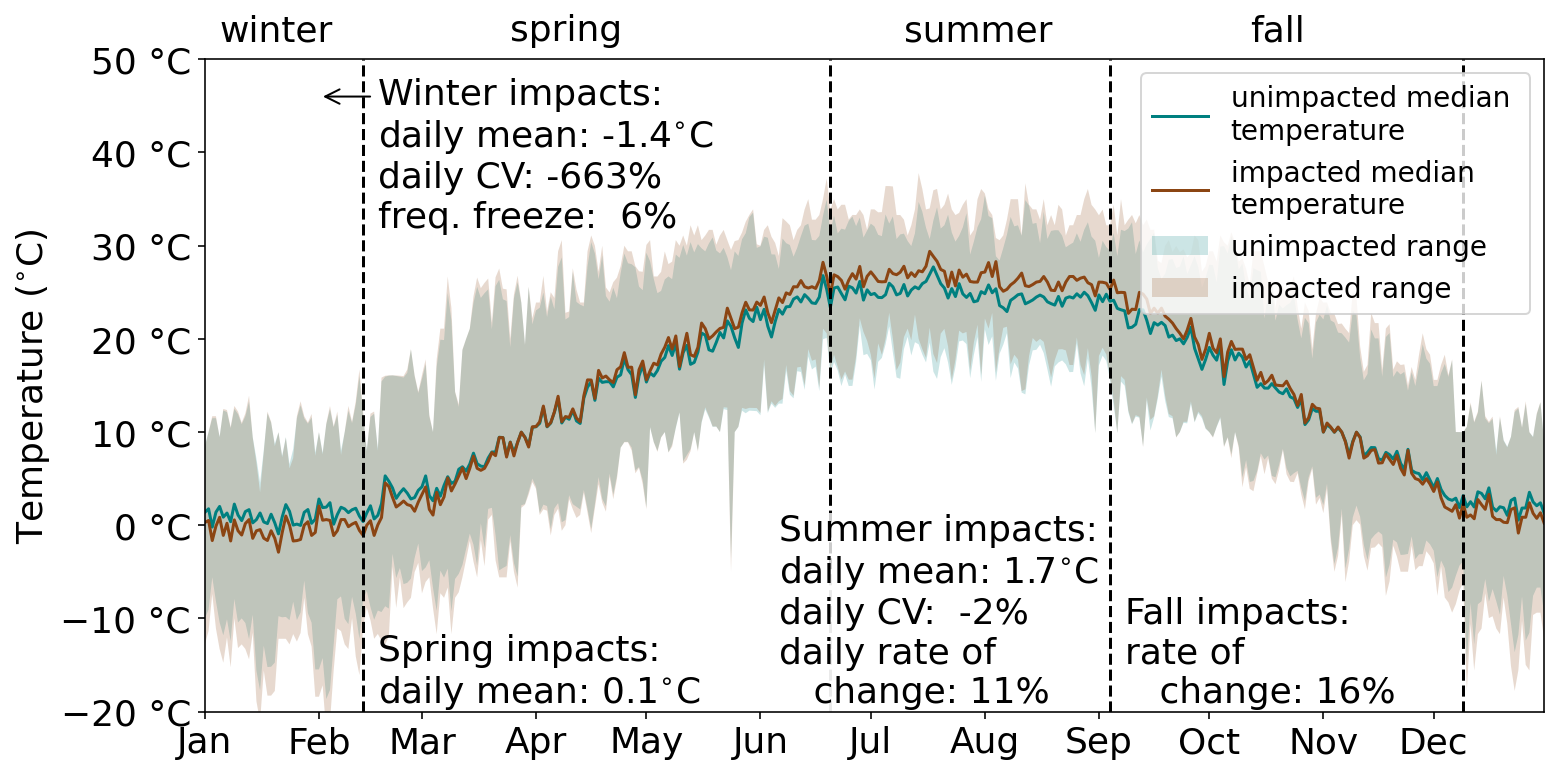

In [31]:
# plot example impacts for one site

site_num = '5370000'
window_size = 5000



flow_data = pd.read_csv(litrev_dir+'streamflow_data/'+site_num+'.csv')
flow_data = flow_data.reset_index()
flow_data['datetime'] = pd.to_datetime(flow_data.datetime)
flow_data = flow_data.set_index('datetime')
flow_data['discharge_cmd'] = flow_data.Q_m3d
flow_data['air_temp'] = flow_data.merge(air_temp,left_index=True,right_index=True,how='left').TMAX.ffill()


baseflow,quickflow = fixed_interval_filter(flow_data.discharge_cmd,window_size)
flow_data['baseflow'] = baseflow
flow_data['quickflow'] = quickflow
flow_data['guess_temp'] = (flow_data.baseflow*baseflow_temp+flow_data.quickflow.mul(flow_data.air_temp,axis=0))
flow_data['guess_temp'] = flow_data.guess_temp.mul(1/flow_data.discharge_cmd,axis=0)

# pick pump rate as 1.25 times baseflow median
pump_rate = np.nanmedian(flow_data.baseflow)*1.25
pumprate_diff = abs(pump_range-pump_rate)
pump_rate = pump_rates[list(pumprate_diff).index(min(pumprate_diff))]

impacts = pd.read_csv(litrev_dir+'pump_impacts/'+str(pump_rate)+'_impacts.csv').drop(columns=['Unnamed: 0','times'])
flow_data = (flow_data.reset_index().merge(impacts,left_index=True,right_index=True)).set_index('datetime')
flow_data['discharge_impact'] = flow_data.discharge_cmd-flow_data.Qs
baseflow_impact,quickflow_impact = fixed_interval_filter(flow_data.discharge_impact,window_size)
flow_data['baseflow_impact'] = baseflow_impact
flow_data['quickflow_impact'] = quickflow_impact
flow_data['impact_temp'] = (flow_data.baseflow_impact*baseflow_temp+flow_data.quickflow_impact.mul(flow_data.air_temp,axis=0))
flow_data['impact_temp'] = flow_data.impact_temp.mul(1/flow_data.discharge_impact,axis=0)

flow_data = flow_data.sort_index()
impacts = calc_metrics(flow_data)
flow_data = flow_data.reset_index()[(flow_data.reset_index().datetime.dt.month!=2)|(flow_data.reset_index().datetime.dt.day!=29)].set_index('datetime')

flow_data['date'] = np.where(flow_data.reset_index().datetime.dt.month>=1,
                             flow_data.reset_index()['datetime'].apply(lambda x: x.replace(year = 1999)),
                             flow_data.reset_index()['datetime'].apply(lambda x: x.replace(year = 1999)))
flow_data1 = flow_data.set_index('date').sort_index()

seasons = calc_season_dates(flow_data1.guess_temp.resample('D').mean())



impactcolor = 'saddlebrown'
basecolor = 'teal'

# plot example impacts
fig,ax = plt.subplots(1,figsize=(12,6))
ax.plot(flow_data1['guess_temp'].resample('D').median(),label='unimpacted median \ntemperature',c=basecolor)
ax.plot(flow_data1['impact_temp'].resample('D').median(),label='impacted median \ntemperature',c=impactcolor)
ax.fill_between(flow_data1.resample('D').mean().index,flow_data1.guess_temp.resample('D').min(),
               flow_data1.guess_temp.resample('D').max(),alpha=0.2,zorder=-2,label='unimpacted range',facecolor=basecolor)
ax.fill_between(flow_data1.resample('D').mean().index,flow_data1.impact_temp.resample('D').min(),
               flow_data1.impact_temp.resample('D').max(),alpha=0.2,zorder=-1,label='impacted range',facecolor=impactcolor)
for i in range(len(seasons)):
    ax.axvline(seasons[i],c='k',linestyle='--')
plt.plot([seasons[1],seasons[1]],[-25,-5],c='white',linewidth=3,alpha=0.6)

ax.set_ylim(-20,50)
ax.set_xlim(pd.to_datetime('1-1-1999'),pd.to_datetime('12-31-1999'))
ax.legend(loc='upper right',fontsize = 14)
ax.yaxis.set_major_formatter(EngFormatter(unit=u"°C"))
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.set_ylabel('Temperature ($^{\circ}$C)',fontsize = fs)
plt.plot([seasons[1],seasons[1]],[-20,1],linewidth=3,c='white',alpha=0.8)


ax.text(pd.to_datetime('3-25-1999'),52,'spring',fontsize = fs)
ax.text(pd.to_datetime('7-10-1999'),52,'summer',fontsize = fs)
ax.text(pd.to_datetime('10-12-1999'),52,'fall',fontsize = fs)
ax.text(pd.to_datetime('1-5-1999'),52,'winter',fontsize = fs)


ax.text(pd.to_datetime('2-17-1999'),-19,'Spring impacts:\ndaily mean: %3.1f' %impacts['spring_mean_daily']+'$^{\circ}$C',#+
       fontsize=fs)
ax.text(pd.to_datetime('2-17-1999'),32,'Winter impacts:\ndaily mean: %3.1f' %impacts['winter_mean_daily']+'$^{\circ}$C'+
       '\ndaily CV: %3.0f' %impacts['winter_CV']+'%'+'\nfreq. freeze: %2.0f' %impacts['winter_freq_freeze']+'%'#+
        ,fontsize=fs)
ax.text(pd.to_datetime('6-6-1999'),-19,'Summer impacts:\ndaily mean: %3.1f' %impacts['summer_mean_daily']+'$^{\circ}$C'+
       '\ndaily CV: %3.0f' %impacts['summer_CV']+'%'+
       '\ndaily rate of \n   change: %2.0f'%impacts['summer_median_daily_roc']+'%'#+'\nmax. date: %3.0f'%impacts['summer_max_date']+' days'#+
        ,fontsize=fs)
ax.text(pd.to_datetime('9-8-1999'),-19,'Fall impacts:\nrate of \n   change: %1.0f' %impacts['fall_roc']+'%',#+
        fontsize=fs)
ax.annotate("", xy=(pd.to_datetime('2-1-1999'), 46), 
            xytext=(pd.to_datetime('2-16-1999'), 46), 
            arrowprops=dict(arrowstyle="->"))
